In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import os

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

* "Microsoft.WebBrowser.Protobuf.UMA.Histograms\\"
    * shows up both in continuous and discrete queries; is this a special type of data-structure?
    
* Questions
    * 'attribute': {'name': 'Confidence:3', 'dataType': 'Double'}, 'values': ['0.5D'], 'children': [], 'isSorted': True} ----> why are column names of the type col_name:%d
    * example when PartitioningColumn not in inputColumns:
        device_id v/s DeviceID
        others?
    * sometimes filter input column something like: partialRowNum0


* TODO: combine this with join tables data; Probably can't draw a lot of conclusion about partitioning etc. w/o considering the join workload

* NormInput vs HashTagInput
* inputSelected vs inputColumns
* #FilterColumns vs #FilterColumnsPerSQL. FilterColumns separate plot;
    * #FilterColumns total used for input
    * #Mean, max/min/std filter columns per job per input
* PartitioningColumn Questions:
    * PartitionColumns vs FilterColumns; How often are these the same??
    * #PartitioningColumn
    * Sanity Check: for an input, the #PartitioningColumn (std) == 0??
    * when are partitionin columns === nan / 0; how often / why? does this mean rr partitioning, or something else?
    * only one column is DESC, 550 are ASC!
* Whats up w/ the outlier inputs, e.g., one with inputColumns std peaking at 100??

* Operator questions
    * What kind of operators? distribution for each kind.
    * how often are there multiple filters on SAME column;
    * mixed operators; pairwise distributions; e.g., range + = operators are very rare
    * QUESTION: don't see ANY like operator?????
    
* VertexCount; what does this signify? how often does this change across inputs?

In [2]:
# FN = "combined-0J-2021-05-22.ss.csv"
# INP_FIELD = "NormInput"
# DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

CLUSTER = "cosmos08"
FN = "../data/{}/raw_views_filters_2021-12-15.ss.csv".format(CLUSTER)
DEDUPFN = FN.replace(".ss.csv", "-dedup.ss.csv")

EXPR_DF_FN = FN.replace("raw_views_filters_2021-12-15.ss.csv", "expr_df.csv")
OP_DF_FN = FN.replace("raw_views_filters_2021-12-15.ss.csv", "op_df.csv")

INP_FIELD = "NormInputHashCode"
#INP_FIELD = "HashTagInput"
FILTER_FIELD = "FilterExpr"
DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

STATCOLS = ["like_ops", "discrete_ops", "cont_ops"]
#STATSTODROP = ["std", "min", "max", "25%", "50%","75%"]
#INP_FIELD = "HashTagInput"

In [3]:
#df = pd.read_csv(FN, sep="|")
#df = pd.read_csv(FN, sep="\t")
#df = pd.read_csv(DEDUPFN, sep="\t")
if os.path.exists(DEDUPFN):
    df = pd.read_csv(DEDUPFN, sep="\t")
else:
    df = pd.read_csv(FN, sep="\t")

In [4]:
#df = df.rename(columns={"#Field:JobGUID":"jobid"})
df = df.rename(columns={"JobGUID":"jobid"})

In [5]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr'],
      dtype='object')

# Duplicate and then execute ---> we could group these together, but probably won't make a big difference in the stats we collect

In [6]:
print(len(set(df[INP_FIELD])))

27327


In [7]:
print(len(df))

916181


In [8]:
# df.groupby(["inputColumns"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).reset_index().describe(percentiles=[0.9,0.99])

In [9]:
# df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index()

In [10]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [11]:
pretty_print(df.groupby([INP_FIELD, FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
                                    ascending=False)["jobid"].describe(percentiles=[0.9,0.99]).\
                                    reset_index().\
            rename(columns={"jobid":"Input, FilterExprNorm \\n Duplicates"}))

index,"Input, FilterExprNorm Duplicates"
count,916181.0
mean,1.0
std,0.0
min,1.0
50%,1.0
90%,1.0
99%,1.0
max,1.0


In [12]:
df = df.drop_duplicates(DEDUP_FIELDS, keep="last")

In [13]:
if not os.path.exists(DEDUPFN):
    df.to_csv(DEDUPFN, sep="\t", index=False)

In [14]:
#df2 = pd.read_csv(DEDUPFN)

In [15]:
#print(df2.keys())
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr'],
      dtype='object')


In [16]:
def qerr(val1, val2):
    val1 = max(1, val1)
    val2 = max(1, val2)
    q = max (float(val1)/val2, float(val2)/val1)
    return q

In [17]:
df["InputCardinality"] = df.apply(lambda x: max(1, x["InputCardinality"]), axis=1)
df["Selectivity"] = df.apply(lambda x: min(float(x["RowCount"])/x["InputCardinality"], 1.0) ,axis=1)

In [18]:
df["QError"] = df.apply(lambda x:  qerr(x["RowCount"], x["EstCardinality"]),axis=1)

In [19]:
#HTML(df["Selectivity"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

# Amount of time spent in filters vs whole jobs

In [20]:
start = time.time()
dbs,seeninps = find_dbs_par(df, INP_FIELD)
print("db assignment took: ", time.time()-start)

db assignment took:  7.385937929153442


In [21]:
for k,v in seeninps.items():
    assert len(v) == 1
    seeninps[k] = list(v)[0]

In [22]:
print(len(seeninps))
print(len(dbs))

27327
18714


In [23]:
print(len(dbs))

18714


In [24]:
numtables = [len(v) for v in dbs.values()]
print(np.mean(numtables), np.percentile(numtables, 50), np.percentile(numtables, 75), 
     np.percentile(numtables, 90),
     np.percentile(numtables, 99),
     np.percentile(numtables, 99.9),
     np.percentile(numtables, 99.999),
     np.max(numtables)
     )

1.1547504542054077 1.0 1.0 1.0 4.0 10.287000000000262 70.6900899999855 72


In [25]:
dbdf = defaultdict(list)
for k,v in dbs.items():
    #print(len(v))
    dbdf["db"].append(k)
    dbdf["numtables"].append(len(v))
dbdf = pd.DataFrame(dbdf)

In [26]:
dbdf["numtables"].describe(percentiles=[0.75, 0.9, 0.99, 0.999])

count    18714.000000
mean         1.154750
std          1.139025
min          1.000000
50%          1.000000
75%          1.000000
90%          1.000000
99%          4.000000
99.9%       10.287000
max         72.000000
Name: numtables, dtype: float64

In [27]:
tmp = dbdf[dbdf["numtables"] >= 2]
tmp["numtables"].describe(percentiles=[0.75, 0.9, 0.99, 0.999])

count    1621.000000
mean        2.786552
std         3.474079
min         2.000000
50%         2.000000
75%         3.000000
90%         4.000000
99%        11.000000
99.9%      63.140000
max        72.000000
Name: numtables, dtype: float64

In [28]:
# import time
# start = time.time()
# parse_filter_exprs(df, INP_FIELD, FILTER_FIELD)
# print("parsing took: ", time.time()-start)

In [29]:
# import copy
# tmp = copy.deepcopy(df.sample(frac=0.001))
# import time
# start = time.time()
# tdf,_ = parse_filter_exprs2(tmp, INP_FIELD, FILTER_FIELD)
# print("parsing took: ", time.time()-start)

In [30]:
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError'],
      dtype='object')


In [31]:
#initdf = copy.deepcopy(df)

In [32]:
#print(len(initdf))

In [33]:
pd.options.mode.chained_assignment = None  # default='warn'

In [34]:
import time
start = time.time()
df,allopdf = parse_filter_exprs_par(df, INP_FIELD, FILTER_FIELD, num_par=32)
print("parsing took: ", time.time()-start)

*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.notlike(search_phrase, "%[!%]%", '\0')
opval:  %[!%]%
*******
*******
likeutil.like(querystring, "%&ea=place%20order%", '\0')
opval:  %&ea=place%20order%
*******
!!Like in Op, but LikeUtil not!!
alldebuginfo.contains("isfractionlikefields")
********************
parsing took:  125.5007393360138


In [35]:
#print(len(df[df.num_ops == =1]))
#df = df[df["num_ops"] != -1]
print(df.keys())
print(allopdf.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs', 'is_id',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'unique_filter_cols2', 'num_unique_ops', 'types_all', 'num_like_cols',
       'num_likes', 'like_lens', 'like_dtype', 'like_kind',
       'num_discrete_consts', 'discrete_type', 'in_ops', 'cont_dtype',
       'cont_type', 'cont_range', 'cont_cols', 'cont_column', 'cont_lt',
       'cont_gt'],
      dtype='object')
Index(['column2', 'op', 'constant', 'opstring', 'dtype', 'optype', 'is_id',
       'exprhash', 'input', 'jobid', 'InputCardinality', 'StageName', 'column',
       'discrete_ops', 'cont_ops', 'like_ops'],
      dtype='object')


In [36]:
for k,v in seeninps.items():
    seeninps[k] = CLUSTER + "-" + v

In [37]:
df["db"] = df.apply(lambda x: seeninps[x[INP_FIELD]],axis=1)
allopdf["db"] = df.apply(lambda x: seeninps[x[INP_FIELD]], axis=1)

In [38]:
df["cluster"] = CLUSTER
allopdf["cluster"] = CLUSTER
df["workload"] = "cosmos"
allopdf["workload"] = "cosmos"

df["input"] = df[INP_FIELD]

In [39]:
#df["cont_column"] = df.apply(lambda x: str(x[INP_FIELD]) + x["cont_column"] ,axis=1)
#allopdf["column"] = allopdf.apply(lambda x: str(x["input"]) + x["column"] ,axis=1)

In [40]:
df.to_csv(EXPR_DF_FN, index=False)
allopdf.to_csv(OP_DF_FN, index=False)

In [41]:
allopdf.keys()

Index(['column2', 'op', 'constant', 'opstring', 'dtype', 'optype', 'is_id',
       'exprhash', 'input', 'jobid', 'InputCardinality', 'StageName', 'column',
       'discrete_ops', 'cont_ops', 'like_ops', 'db', 'cluster', 'workload'],
      dtype='object')

In [42]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs', 'is_id',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'unique_filter_cols2', 'num_unique_ops', 'types_all', 'num_like_cols',
       'num_likes', 'like_lens', 'like_dtype', 'like_kind',
       'num_discrete_consts', 'discrete_type', 'in_ops', 'cont_dtype',
       'cont_type', 'cont_range', 'cont_cols', 'cont_column', 'cont_lt',
       'cont_gt', 'db', 'cluster', 'workload', 'input'],
      dtype='object')

In [124]:
df[["cont_ops", "discrete_ops", "like_ops", "is_id"]].mean()

cont_ops        0.721180
discrete_ops    0.527761
like_ops        0.035260
is_id           0.022832
dtype: float64

In [45]:
allopdf[["cont_ops", "discrete_ops", "like_ops", "is_id"]].mean()

cont_ops        0.216366
discrete_ops    0.753992
like_ops        0.029643
is_id           0.108391
dtype: float64

In [46]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
STATSTODROP = ["std", "min", "max", "99%"]
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [47]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
STATSTODROP = ["std", "min", "max"]
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     #.sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [48]:
dbcounts = df.groupby("db").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
dbcounts["jobid"].describe(percentiles=[0.9,0.99])

count    15943.000000
mean        56.384557
std       1214.891450
min          1.000000
50%          2.000000
90%         15.000000
99%        307.060000
max      77531.000000
Name: jobid, dtype: float64

In [49]:
seldbs = dbcounts[dbcounts["jobid"] >= 10]["db"].values
#seldbs

In [50]:
dbmeans = df.groupby(["db"])[["cont_ops", "discrete_ops", "like_ops", "ExclusiveTime"]].mean().reset_index()

In [51]:
dbmeans["ExclusiveTime"].describe()

count    1.594300e+04
mean     1.209499e+04
std      2.460394e+05
min      0.000000e+00
25%      4.228571e-02
50%      2.900000e+00
75%      6.349700e+01
max      1.284382e+07
Name: ExclusiveTime, dtype: float64

In [52]:
dbmeans = dbmeans[dbmeans.db.isin(seldbs)]

In [53]:
dbmeans["ExclusiveTime"].describe()

count    2.144000e+03
mean     8.994912e+03
std      1.958103e+05
min      0.000000e+00
25%      1.144980e-01
50%      4.402779e+00
75%      1.185249e+02
max      8.707421e+06
Name: ExclusiveTime, dtype: float64

In [54]:
dbmeans.describe(percentiles=[0.25, 0.75, 0.9, 0.99])

,cont_ops,discrete_ops,like_ops,ExclusiveTime
count,2144.000000,2144.000000,2144.000000,2.144000e+03
mean,0.275279,0.720775,0.057157,8.994912e+03
std,0.346049,0.343673,0.157129,1.958103e+05
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.500000,0.000000,1.144980e-01
50%,0.097800,0.900000,0.000000,4.402779e+00
75%,0.464286,1.000000,0.017317,1.185249e+02
90%,0.952033,1.000000,0.185185,1.120472e+03
99%,1.000000,1.000000,0.985075,7.496981e+04
max,1.000000,1.000000,1.000000,8.707421e+06


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


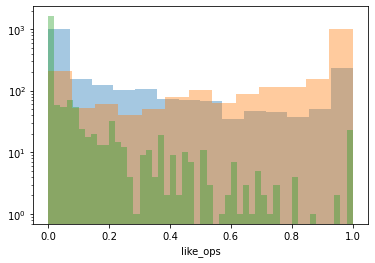

In [55]:
sns.distplot(dbmeans["cont_ops"], kde=False)
sns.distplot(dbmeans["discrete_ops"], kde=False)
sns.distplot(dbmeans["like_ops"], kde=False)
plt.yscale("log")

<AxesSubplot:xlabel='cont_ops', ylabel='discrete_ops'>

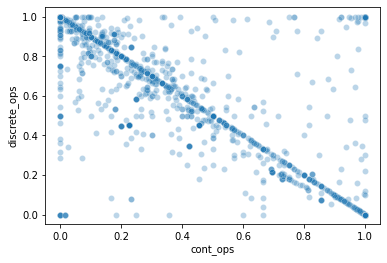

In [56]:
sns.scatterplot(data=dbmeans, x="cont_ops", y="discrete_ops", alpha=0.3)

In [57]:
# TYPECOLS = ["discrete_ops", "cont_ops", "like_ops"]
# timedata = defaultdict(list)

# for db in seldbs:
#     tmp1 = df[df.db == db]
#     totaltime = float(tmp1["ExclusiveTime"].sum())
#     if totaltime == 0.0:
#         continue
#     print(len(tmp1))
#     timedata["db"].append(db)
#     timedata["total"].append(totaltime)
#     #assert totaltime != 0.0
#     for col in TYPECOLS:
#         tmp2 = tmp1[tmp1[col] == 1]
#         curtime = tmp2["ExclusiveTime"].sum()
#         timedata[col].append(curtime / totaltime)

In [58]:
# tdf = pd.DataFrame(timedata)
# tdf["total"] = tdf.apply(lambda x: int(x["total"]/3600), axis=1)

In [59]:
# tdf.describe(percentiles=[0.75, 0.8, 0.9, 0.99])

In [60]:
# sns.distplot(tdf["cont_ops"], kde=False)
# sns.distplot(tdf["discrete_ops"], kde=False)
# sns.distplot(tdf["like_ops"], kde=False)
# plt.yscale("log")

In [61]:
# sns.scatterplot(data=tdf, x="cont_ops", y="discrete_ops", alpha=0.3)

In [62]:
# sns.scatterplot(data=tdf, x="like_ops", y="discrete_ops", alpha=0.3)

<AxesSubplot:xlabel='like_ops', ylabel='discrete_ops'>

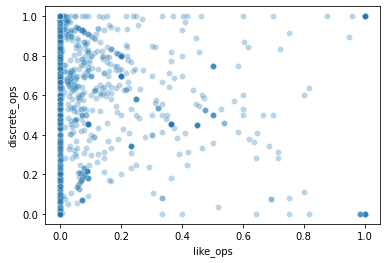

In [63]:
sns.scatterplot(data=dbmeans, x="like_ops", y="discrete_ops", alpha=0.3)

In [64]:
# TODO: correlation b/w like_ops time % and like_ops workload %

In [65]:
df.groupby(["cont_ops", "discrete_ops","like_ops", "regex_ops"])["ExclusiveTime"].sum().reset_index()\
    .sort_values(by="ExclusiveTime", ascending=False)

,cont_ops,discrete_ops,like_ops,regex_ops,ExclusiveTime
3,1,0,0,0,8.441245e+08
1,0,1,0,0,4.675250e+08
2,0,1,1,0,1.421382e+08
0,0,0,1,0,1.148141e+08
5,1,1,0,0,5.450022e+07
6,1,1,1,0,2.842070e+07
4,1,0,1,0,2.991782e+06


# continuous range visualization

In [66]:
import math
print(len(df))
dfcont = df[df.cont_ops == 1]
dfr = dfcont[dfcont.cont_dtype == "date"]
dfr = dfr[dfr["cont_range"] > 0.0]

dfr["cont_range_days"] = dfr.apply(lambda x: int(x["cont_range"] / 86400.0) ,axis=1)
dfr["cont_range_hours"] = dfr.apply(lambda x: int(x["cont_range"] / 3600.0) ,axis=1)

dfr = dfr[dfr["cont_range_days"] >= 0.0]
#dfr = dfr[dfr["cont_range_days"] <= 3600.0]

print(len(dfr))

HTML(dfr.groupby(["cont_dtype"])["cont_range_days"].describe(percentiles=[0.25, 0.40,
                            0.6, 0.75, 0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

898939
39852


cont_dtype,count,mean,std,min,25%,40%,50%,60%,75%,90%,99%,max
date,39852.0,61130.524967,467791.29087,0.0,0.0,0.0,0.0,1.0,42.0,1418.0,3652058.0,3652058.0


In [67]:
dbcounts = dfr.groupby("db").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
seldbs2 = dbcounts[dbcounts["jobid"] >= 10]["db"].values

In [68]:
# print(len(set(dfr["db"])))
# dfr = dfr[dfr.db.isin(seldbs2)]
# fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
# print(len(set(dfr["db"])))
# sns.barplot(data=dfr, y="cont_range_days", x="db", ci="sd", color="b", ax=ax)
# plt.yscale("log")

223
42


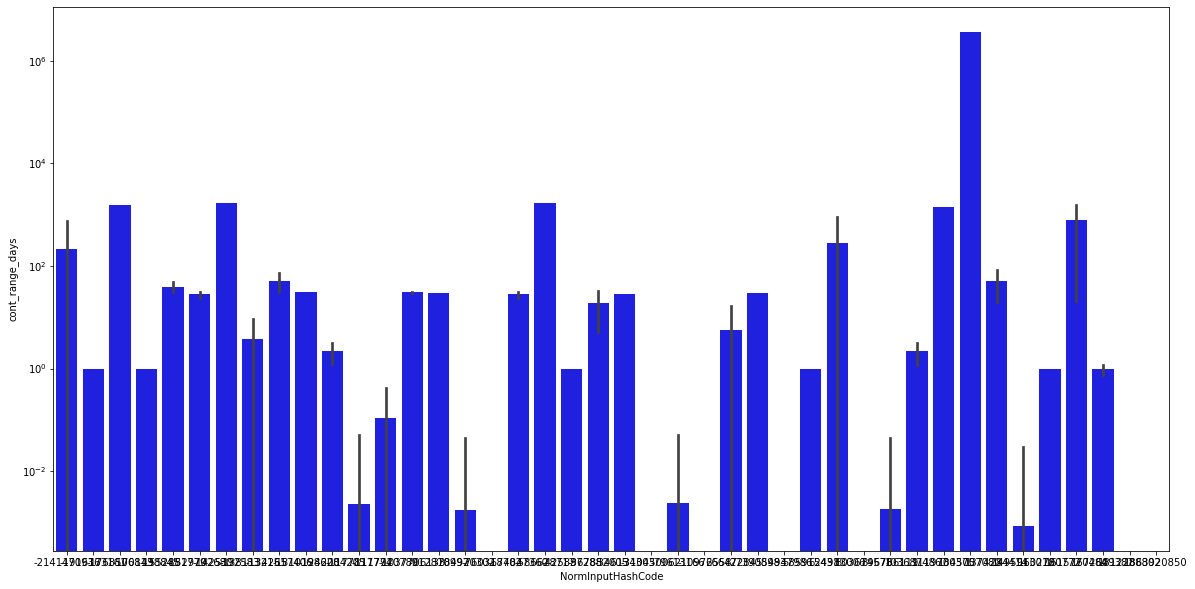

In [69]:
print(len(set(dfr[INP_FIELD])))
dbcounts = dfr.groupby(INP_FIELD).count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
selinps = dbcounts[dbcounts["jobid"] >= 100][INP_FIELD].values
tmp = dfr[dfr[INP_FIELD].isin(selinps)]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
print(len(set(tmp[INP_FIELD])))
sns.barplot(data=tmp, y="cont_range_days", x=INP_FIELD, ci="sd", color="b", ax=ax)
plt.yscale("log")

229
42


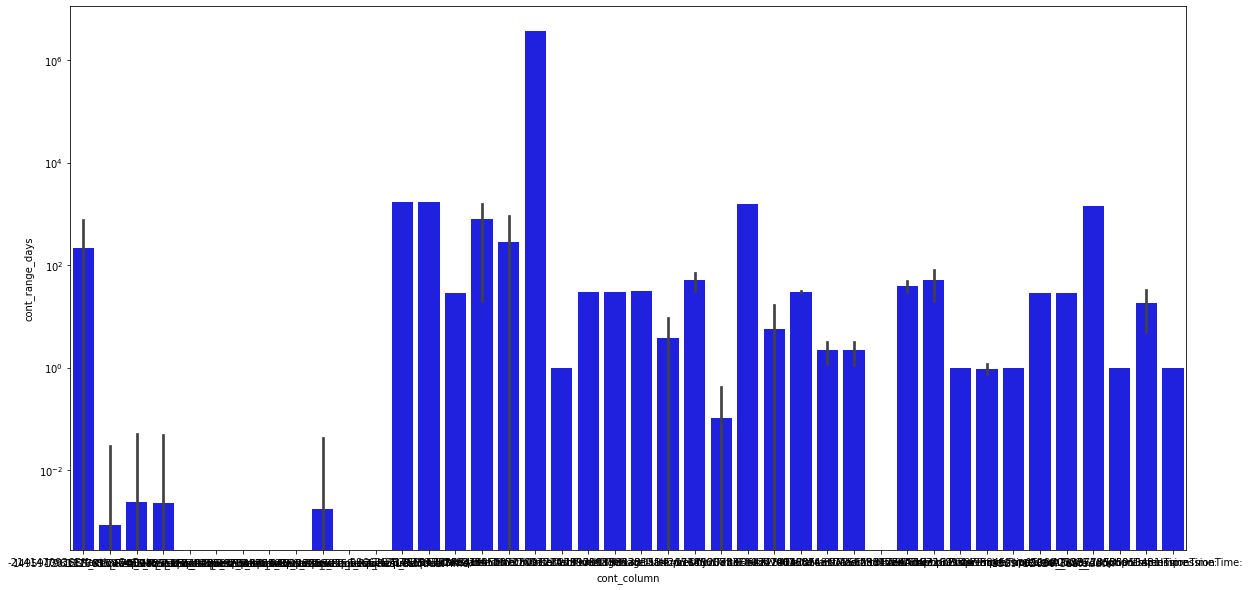

In [70]:
print(len(set(dfr["cont_column"])))
dbcounts = dfr.groupby("cont_column").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
selinps = dbcounts[dbcounts["jobid"] >= 100]["cont_column"].values
tmp = dfr[dfr["cont_column"].isin(selinps)]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
print(len(set(tmp["cont_column"])))
sns.barplot(data=tmp, y="cont_range_days", x="cont_column", ci="sd", color="b", ax=ax)
plt.yscale("log")

In [71]:
#set(tmp["cont_range_days"])

In [72]:
colranges = tmp.groupby("cont_column")["cont_range_days"].nunique().reset_index()
#.sort_values(by="cont_range_days", ascending=False)

In [73]:
#chosencol = colranges["cont_column"].values[1]

In [78]:
def get_cont_xys_from_exprdf(df):
    #minc = min(df["constant"])
    #maxc = max(inpdf["constant"])
    print(min(df["cont_lt"]))
    df["cont_gt"] /= 86400.0
    df["cont_lt"] /= 86400.0
    
    allminvals = df["cont_gt"].values
    allmaxvals = df["cont_lt"].values
    minc = min(allminvals)
    maxc = max(allmaxvals)
    print(minc, maxc)
    pdata = defaultdict(list)
    ranges = []
    inpname = df["cont_column"].values[0]
    
    df = df.sort_values(by="cont_gt")
    #df = df.sort_values(by="InputCardinality")
    idx = 0
    
    for ei,row in df.iterrows():
        idx += 1
        maxv = row["cont_lt"]
        minv = row["cont_gt"]
        
        ranges.append((maxv-minv))

        pdata["x"].append(minv)
        # adding minv to y so as to implicitly sort it by minimum x-values
        pdata["y"].append(idx)
        pdata["x"].append(maxv)
        pdata["y"].append(idx)

        pdata["expr"].append(ei)
        pdata["expr"].append(ei)

        #pdata["yorder"].append(minv)
        #pdata["yorder"].append(minv)
        pdata["inputcol"].append(inpname)
        pdata["inputcol"].append(inpname)
        
        pdata["InputCardinality"].append(row["InputCardinality"])
        pdata["InputCardinality"].append(row["InputCardinality"])
    
    print(np.mean(ranges), np.min(ranges), np.percentile(ranges, 90), np.percentile(ranges,99), np.max(ranges))
    
    #pdata = pdata.sort_values(by="yorder")
    #pdata.index = np.arange(1, len(df) + 1)
    
    return pd.DataFrame(pdata)

def plot_cont_pdata(pdata):
    print(len(pdata))
    if len(pdata) > 10000:
        pdata = pdata.sample(frac=0.1)
    
    inp = pdata["inputcol"].values[0]
    fn = "./range_filter_results/" + CLUSTER + "-" + inp + ".png"
    
    plt.figure(figsize=(10,10))
    plt.title("Input: " + str(inp))
    sns.lineplot(data=pdata, x="x", y="y", hue="expr")
    plt.legend().remove()
    #plt.show()
    plt.savefig(fn) 
    plt.show()
    plt.close()
    
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
#     plt.title("Input: " + str(inp))
#     sns.lineplot(data=pdata, x="x", y="y", hue="expr", ax=axs[0])
#     #plt.legend().remove()
    
#     sns.barplot(data=pdata, x="y", y="InputCardinality", ax=axs[1])
    
#     plt.show()
    #plt.close()

1635739200.0
18901.166666666668 18962.208333333332
30.497132616486184 30.04166666666424 31.0 31.0 31.0
930


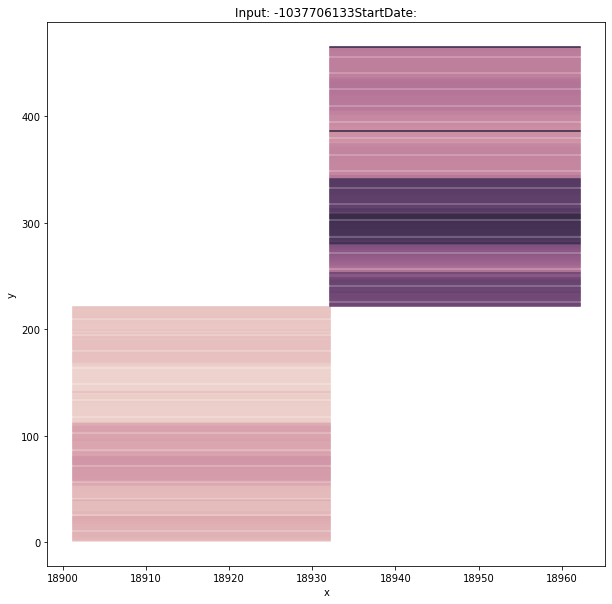

1636812000.0
18944.541666666668 18975.70832175926
0.04163501630555287 0.020833333332120674 0.041666666667879326 0.041666666667879326 0.041666666667879326
3180


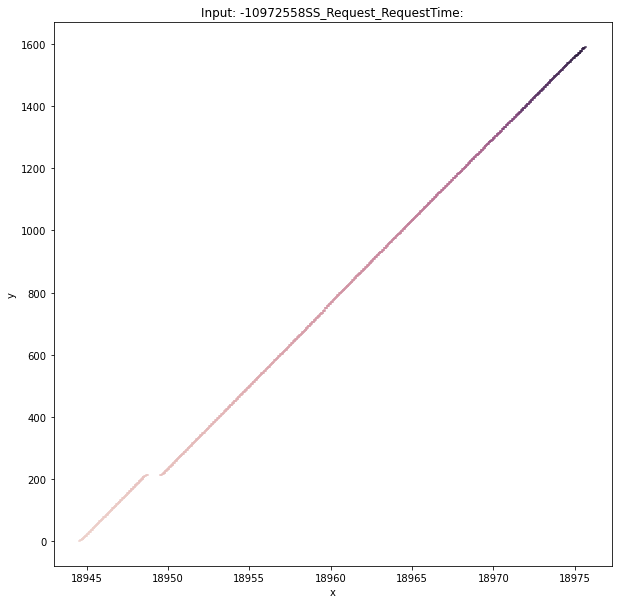

1635825540.0
18932.166666666668 18974.833333333332
0.25086620205640875 0.125 1.0416550925947377 1.0416550925947377 1.0416550925947377
562


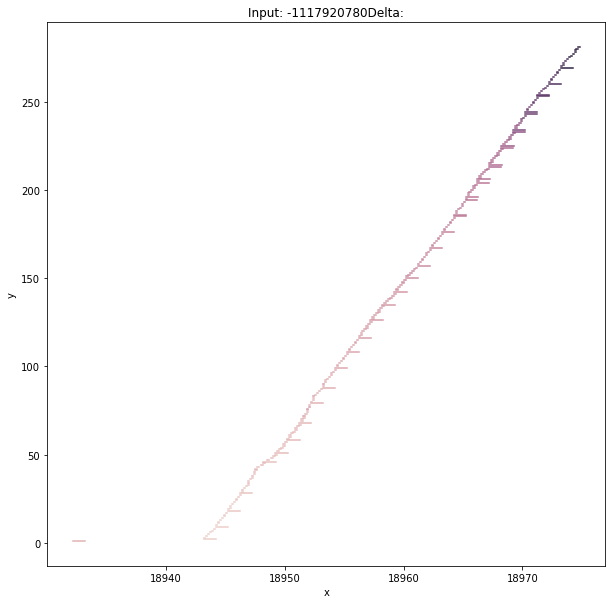

1636812000.0
18944.541666666668 18975.541666666668
0.04630032948682312 0.020833333332120674 0.041666666667879326 0.041666666667879326 1.25
1762


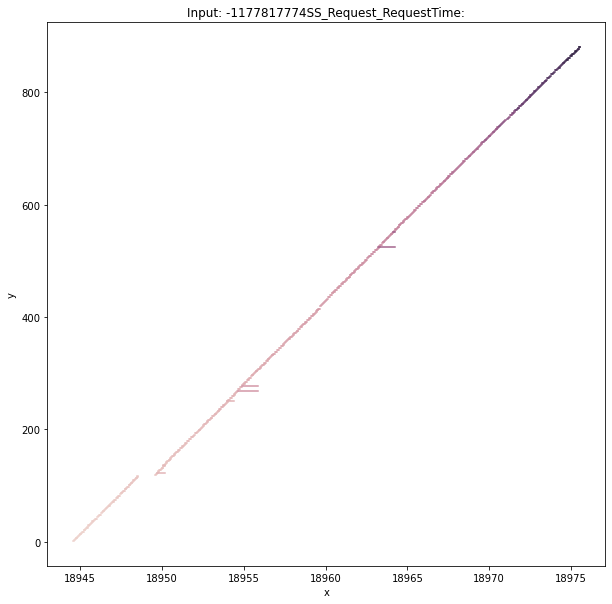

1636779600.0
18942.208333333332 18969.208333333332
2.384722165506117 1.0 3.0 5.780000000000001 7.0
246


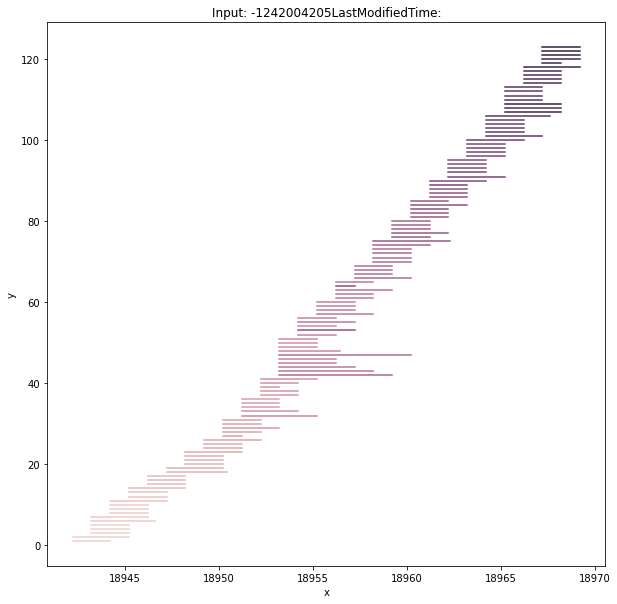

1630209600.0
18837.166666666668 18976.208333333332
30.996971899222952 28.0 31.04166666666424 31.04166666666424 31.04166666666424
688


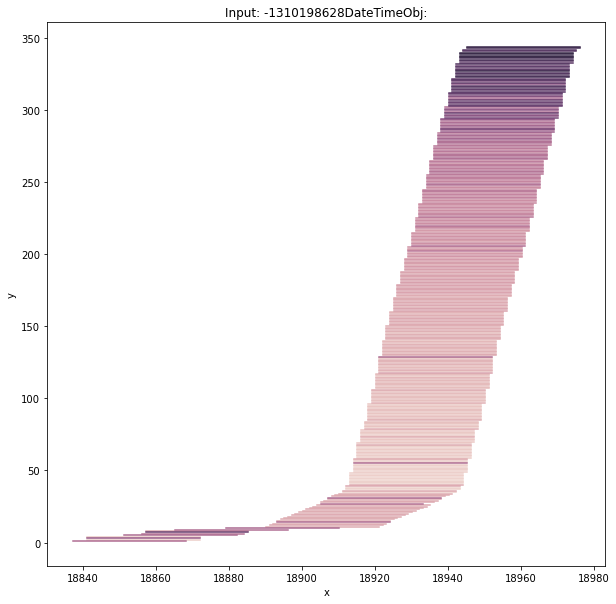

1631073540.0
18861.166666666668 18975.20832175926
51.794805863539004 0.041666666667879326 61.12498842592322 61.12498842592322 61.12498842592322
6584


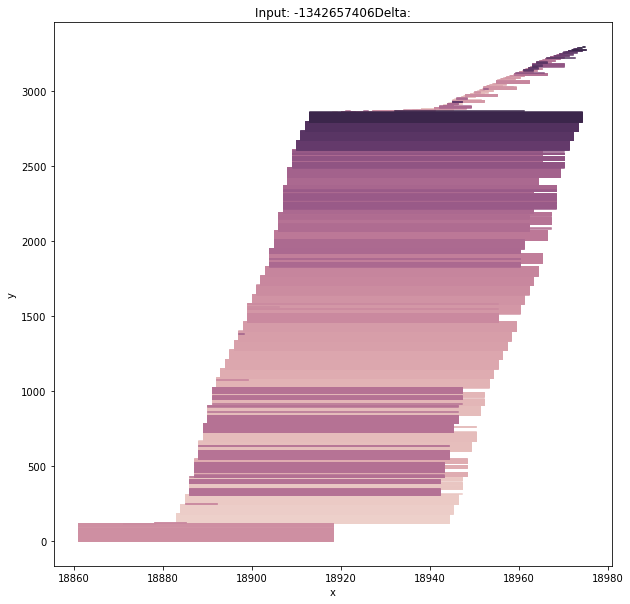

1629604800.0
18841.166666666668 18975.20763888889
3.984682921715832 0.9993055555569299 14.99930555555693 27.99998842592322 34.99998842592322
2164


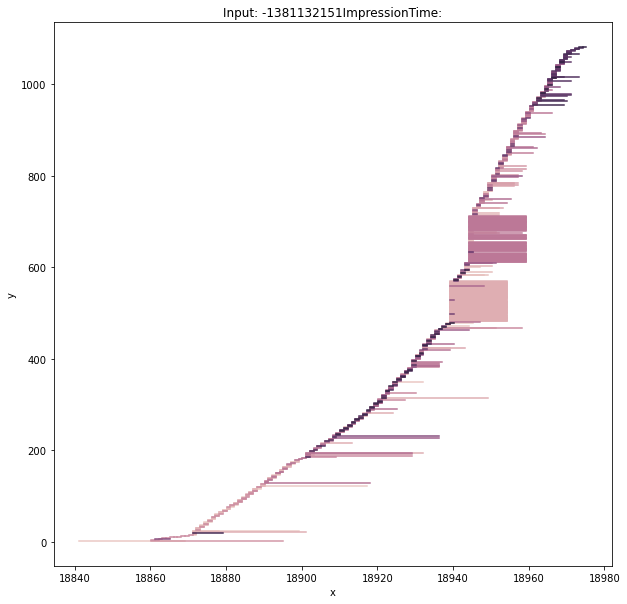

1636866000.0
17284.166666666668 18976.166666666668
1676.8874999999987 1661.0416666666642 1689.0041666666664 1691.7004166666652 1692.0
1440


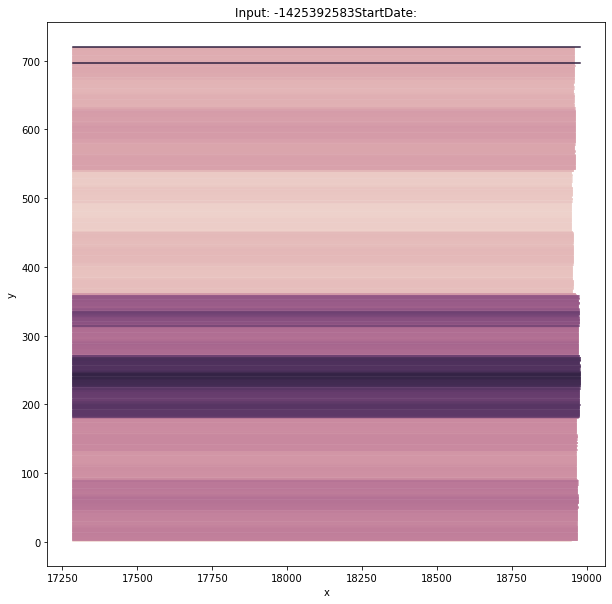

1636603200.0
18913.166666666668 18974.166666666668
28.983333333334304 28.95833333333576 29.0 29.0 29.0
580


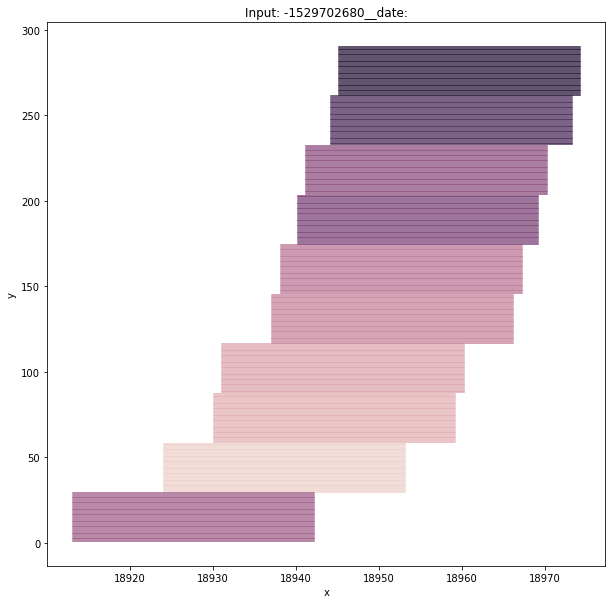

1636257600.0
18921.166666666668 18974.208333333332
39.57835276967692 17.0 51.04166666666424 53.04166666666424 53.04166666666424
2058


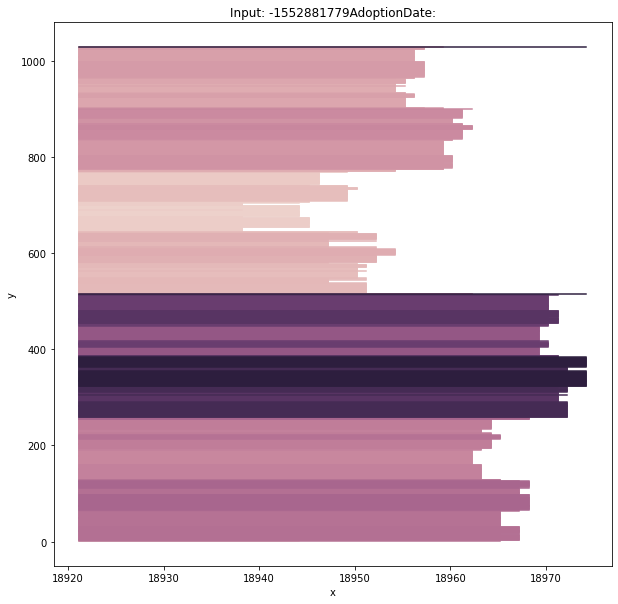

1627876800.0
18840.166666666668 18974.208333333332
1.0003930817609834 1.0 1.0 1.0 1.0416666666642413
424


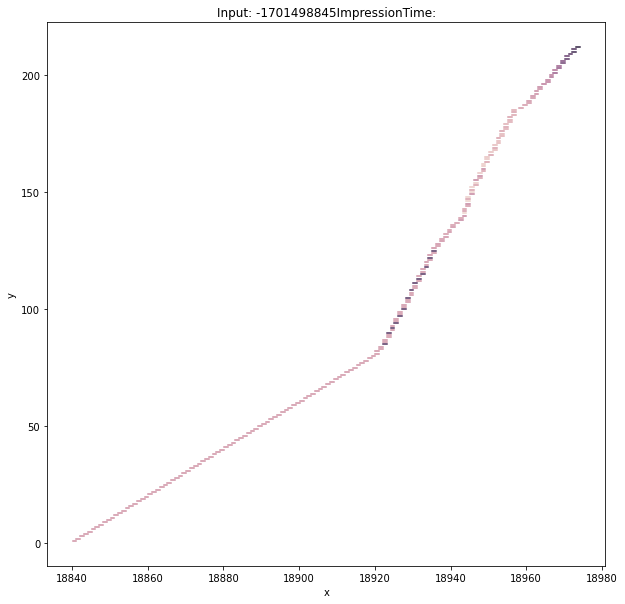

1636855200.0
17399.0 18975.875
1563.0342741935478 1546.0833333333321 1574.1666666666679 1576.64375 1576.875
372


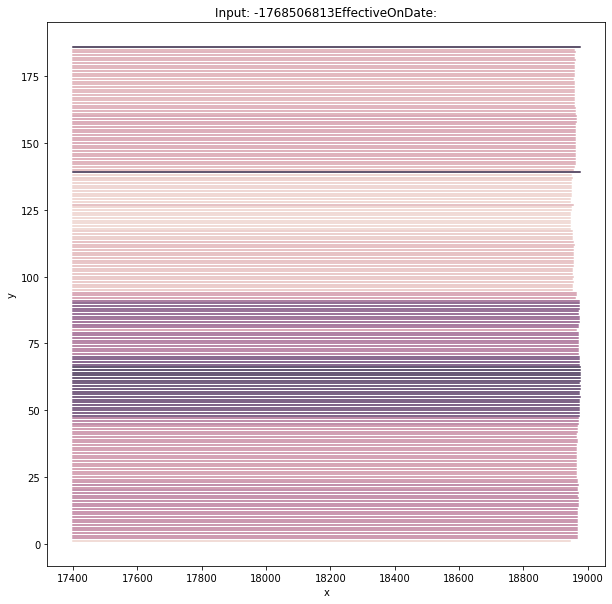

1631160000.0
18878.166666666668 18952.208333333332
1.00057870370367 1.0 1.0 1.0237499999986173 1.0416666666642413
288


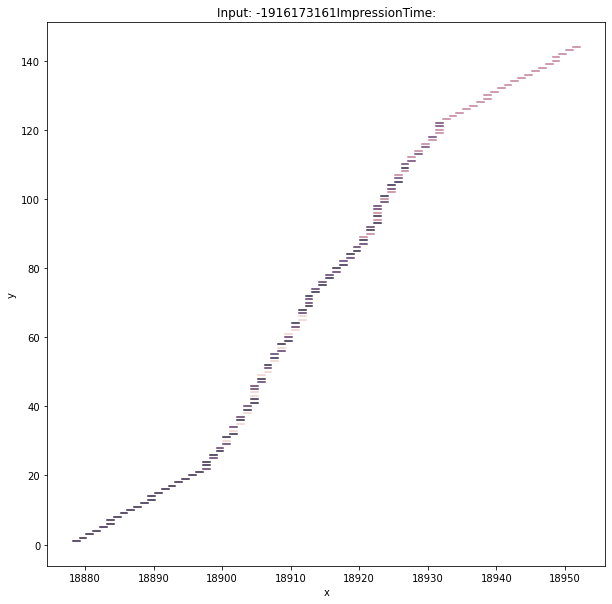

1609455600.0
17313.0 18975.791666666668
211.50600282485874 0.04166666666424135 1638.5 1659.65 1662.0
472


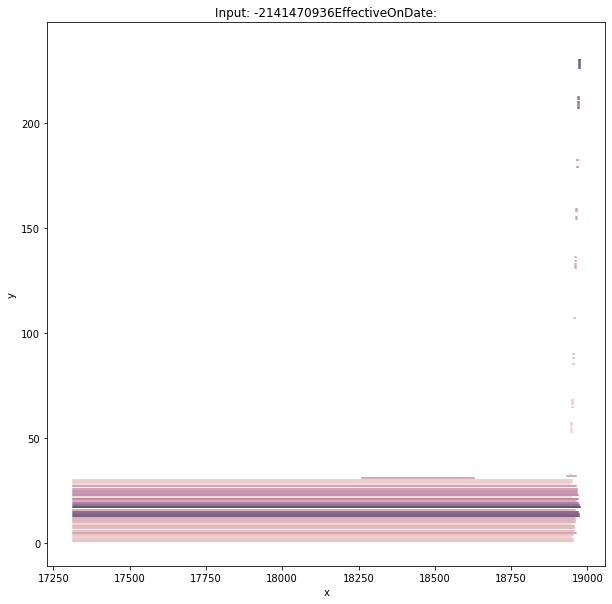

1636812000.0
18944.541666666668 18975.541666666668
0.0416661830703026 0.041655092591099674 0.041666666667879326 0.041666666667879326 0.041666666667879326
1436


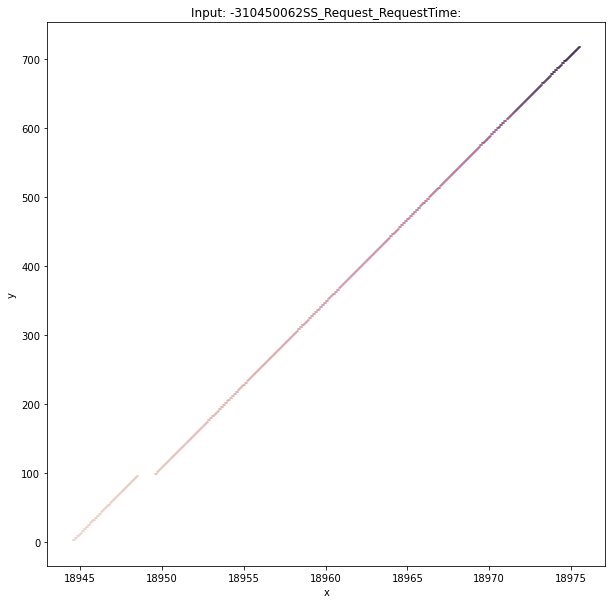

1636779600.0
18916.166666666668 18975.208333333332
28.03102836879252 28.0 28.04166666666424 28.04166666666424 28.04166666666424
282


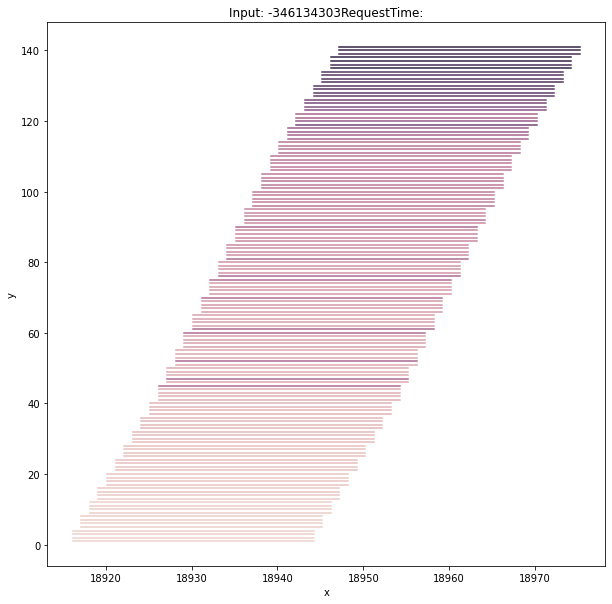

1631160000.0
18878.166666666668 18969.208333333332
18.61477135980593 1.0 29.04166666666424 29.04166666666424 29.04166666666424
554


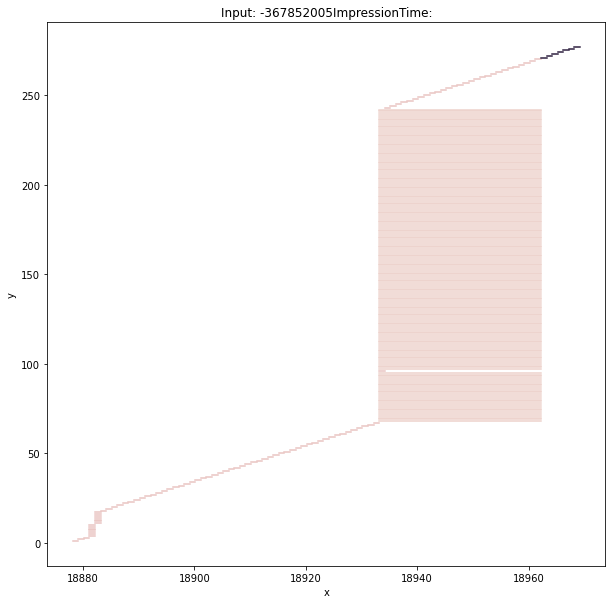

1630555200.0
18871.166666666668 18960.208333333332
1.0004295532645797 1.0 1.0 1.0029166666664966 1.0416666666642413
388


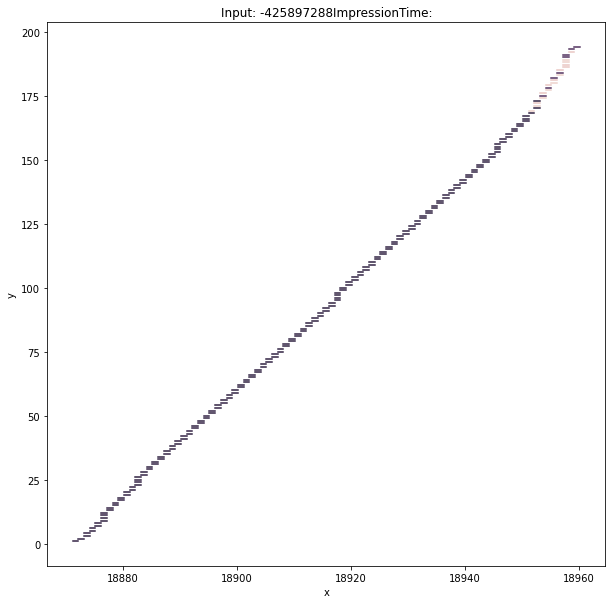

1636866000.0
17284.166666666668 18976.166666666668
1676.8874999999987 1661.0416666666642 1689.0041666666664 1691.7004166666652 1692.0
1440


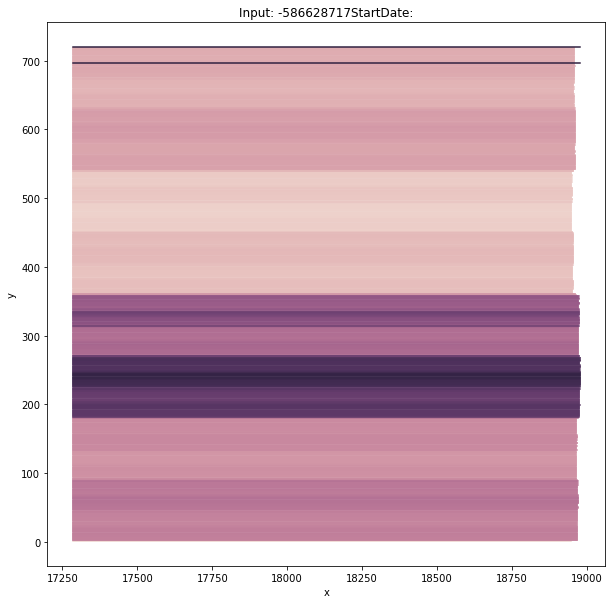

1636603200.0
18913.166666666668 18974.166666666668
28.983333333334304 28.95833333333576 29.0 29.0 29.0
580


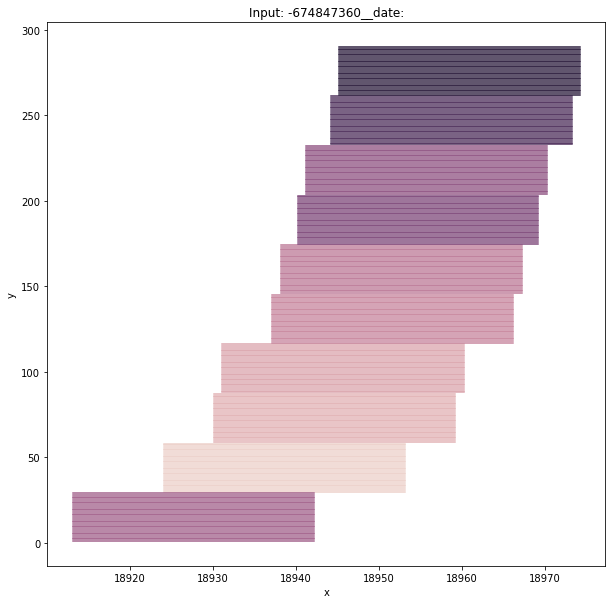

1636812000.0
18944.541666666668 18975.70832175926
0.041641261874828625 0.020833333332120674 0.041666666667879326 0.041666666667879326 0.041666666667879326
4616


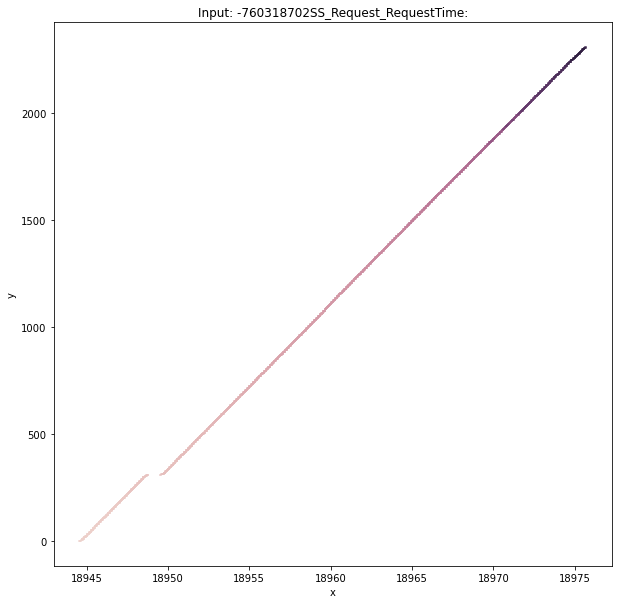

1636812000.0
18944.541666666668 18975.70832175926
0.04351558495116976 0.020833333332120674 0.041666666667879326 0.041666666667879326 1.25
4624


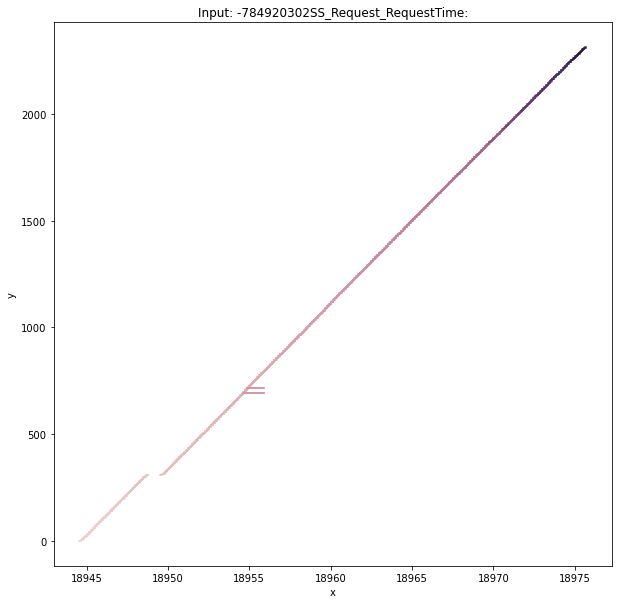

1636812000.0
18944.208333333332 18975.70832175926
0.05727243286468556 0.020833333332120674 0.041666666667879326 0.75 1.37430555555693
3288


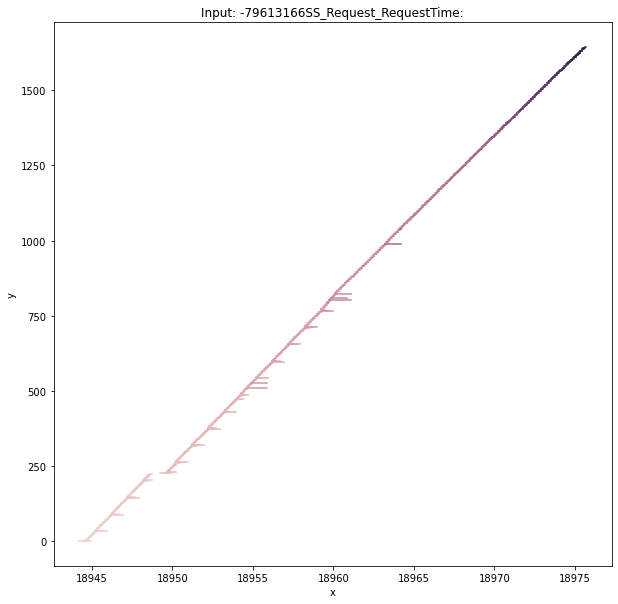

1638334800.0
18932.166666666668 18962.208333333332
30.04166666666424 30.04166666666424 30.04166666666424 30.04166666666424 30.04166666666424
250


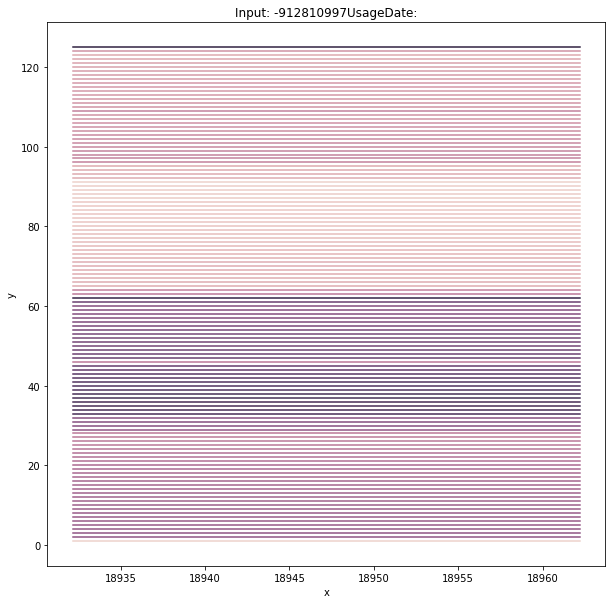

1636779600.0
18942.208333333332 18975.208333333332
2.395080237057984 1.0 3.0 5.639999999999986 7.0
274


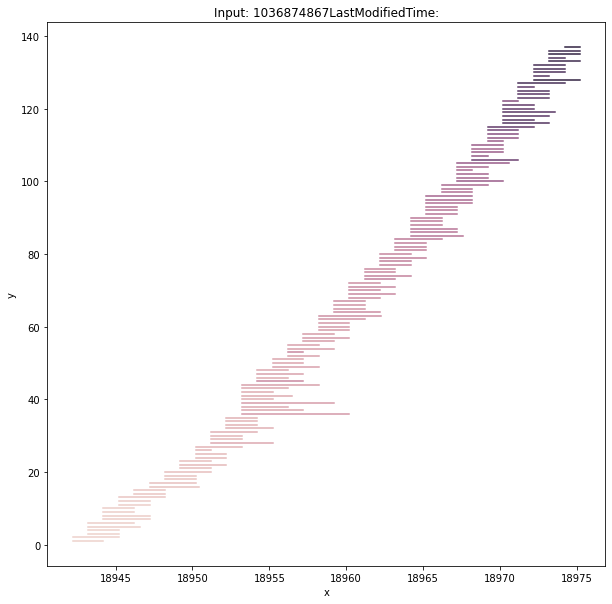

1637298000.0
17532.208333333332 18964.208333333332
1425.0345313601129 1418.0 1432.0 1432.0 1432.0
5676


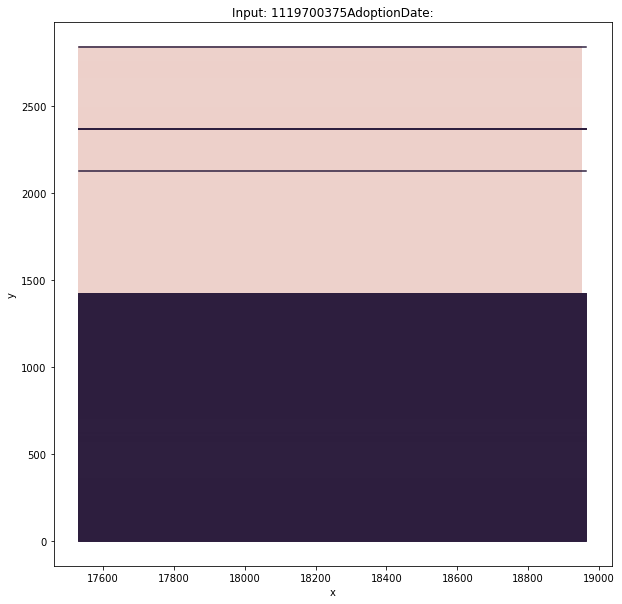

253402300799.0
-719162.0 2932896.999988426
3652058.999988427 3652058.999988426 3652058.999988426 3652058.999988426 3652058.999988426
1330


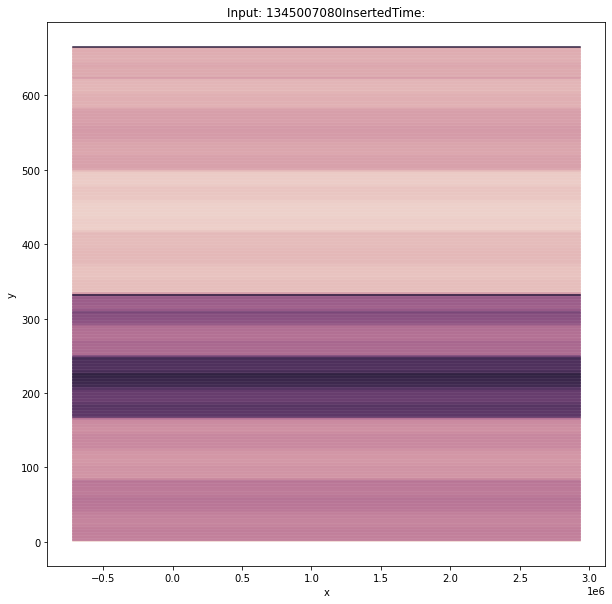

1627790399.0
18823.166666666668 18970.20763888889
50.872506944442925 1.0 84.04166666666424 84.04166666666424 84.04166666666424
2580


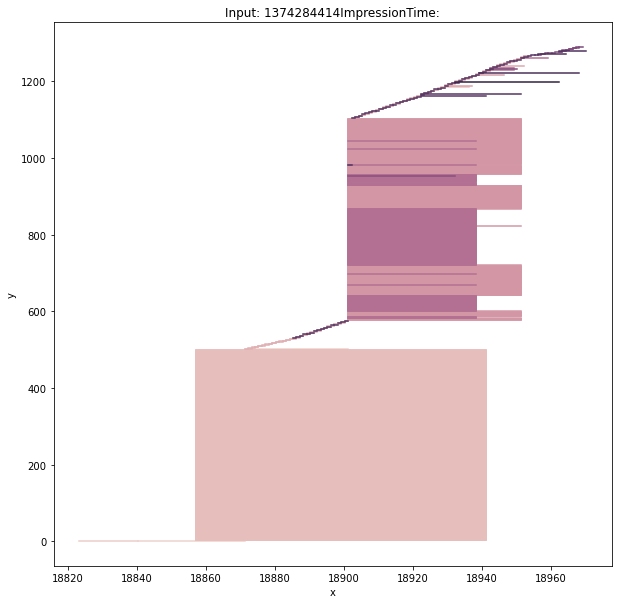

1636812000.0
18944.208333333332 18975.70832175926
0.051452627250907844 0.020833333332120674 0.041666666667879326 0.5 1.37430555555693
4718


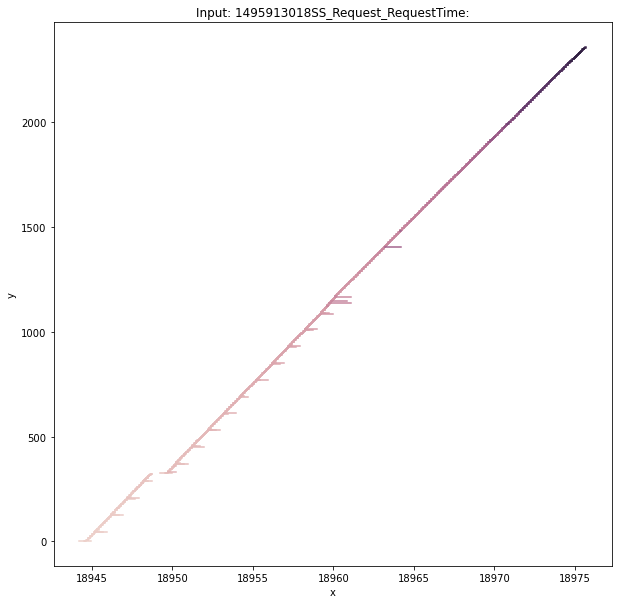

1636866000.0
18944.208333333332 18975.208333333332
1.0 1.0 1.0 1.0 1.0
1560


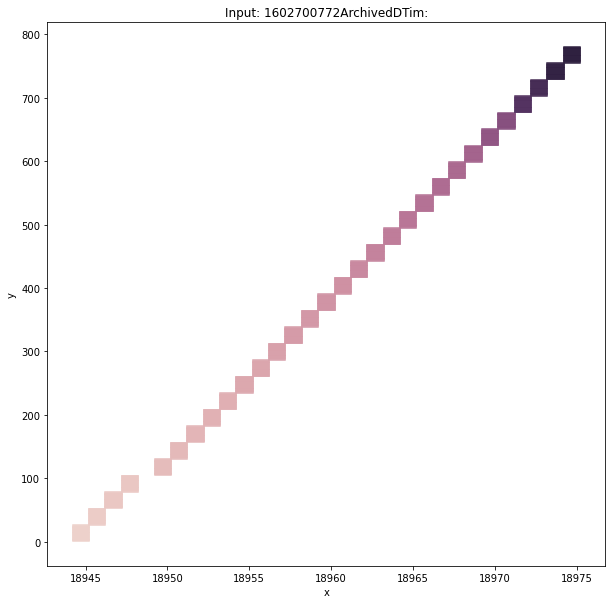

1609455600.0
17399.0 18975.0
798.6741071428563 0.04166666666424135 1570.8624999999988 1575.8529166666656 1576.0
224


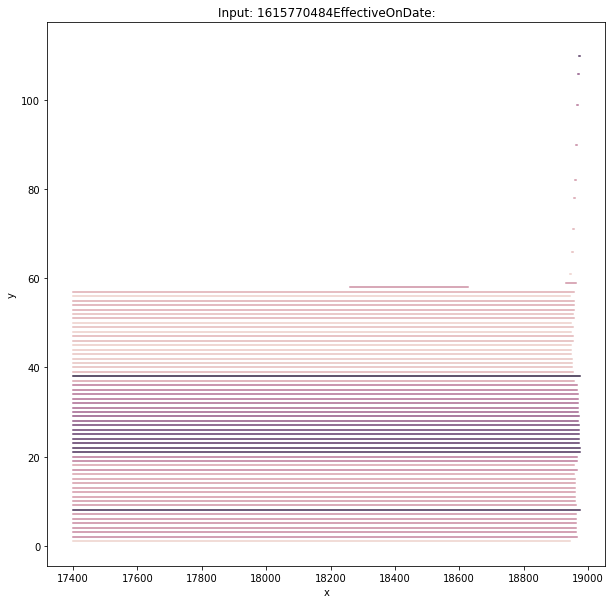

1625198400.0
18809.166666666668 18975.166666666668
0.9989095500459771 0.9583333333357587 1.0 1.0416666666642413 1.0416666666642413
1452


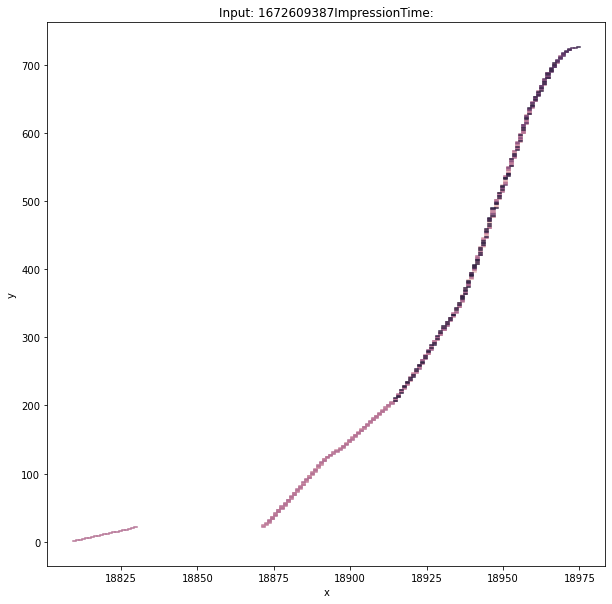

1636812000.0
18944.541666666668 18975.541666666668
0.04166618374290006 0.041655092591099674 0.041666666667879326 0.041666666667879326 0.041666666667879326
1438


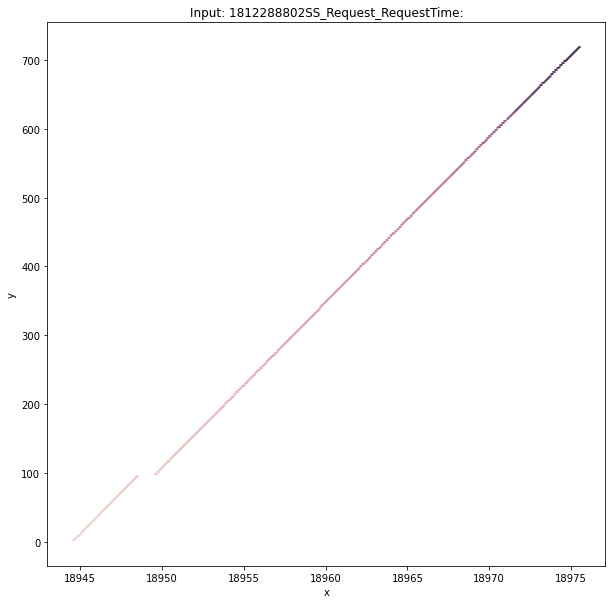

1636812000.0
18944.541666666668 18975.70832175926
0.041641261874828625 0.020833333332120674 0.041666666667879326 0.041666666667879326 0.041666666667879326
4616


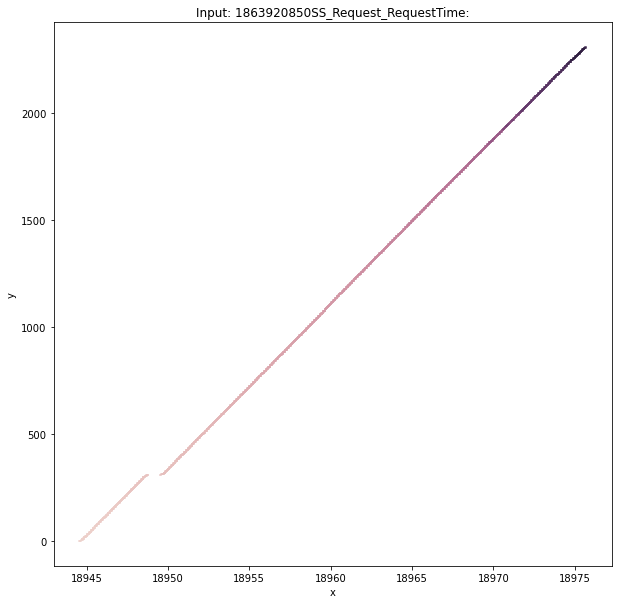

1638334800.0
18932.166666666668 18962.208333333332
30.04166666666424 30.04166666666424 30.04166666666424 30.04166666666424 30.04166666666424
250


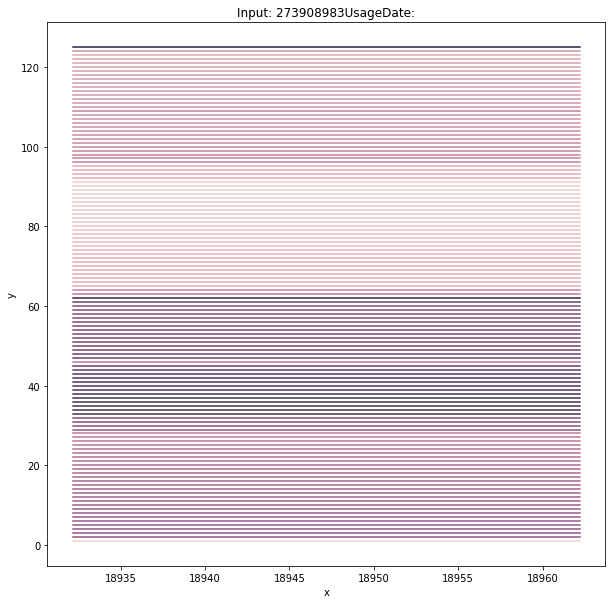

1636812000.0
18944.541666666668 18975.70832175926
0.041641261874828625 0.020833333332120674 0.041666666667879326 0.041666666667879326 0.041666666667879326
4616


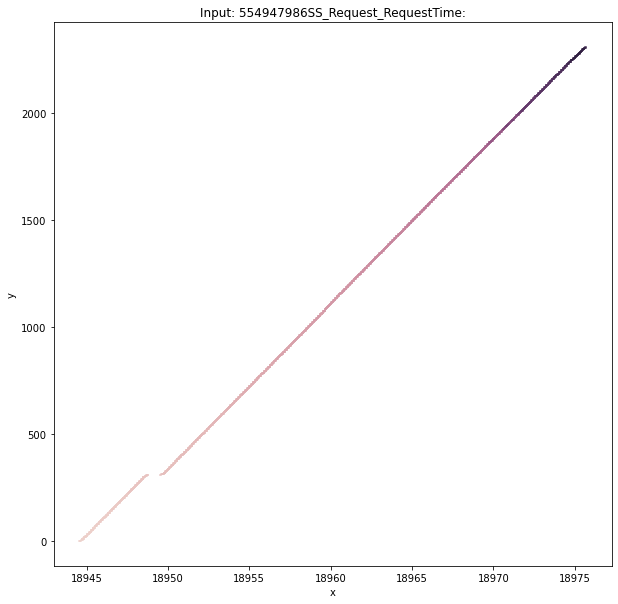

1638421200.0
18962.208333333332 18972.208333333332
1.0 1.0 1.0 1.0 1.0
280


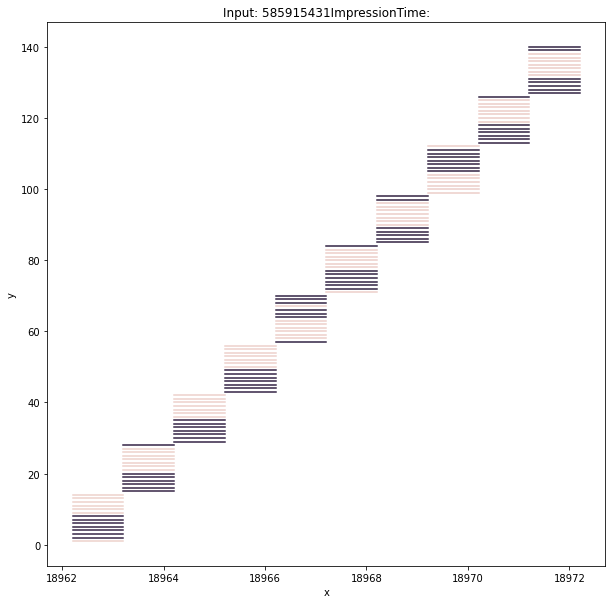

1609455600.0
17313.0 18975.958333333332
282.47260273972574 0.04166666666424135 1645.9583333333321 1660.9583333333321 1662.9583333333321
1022


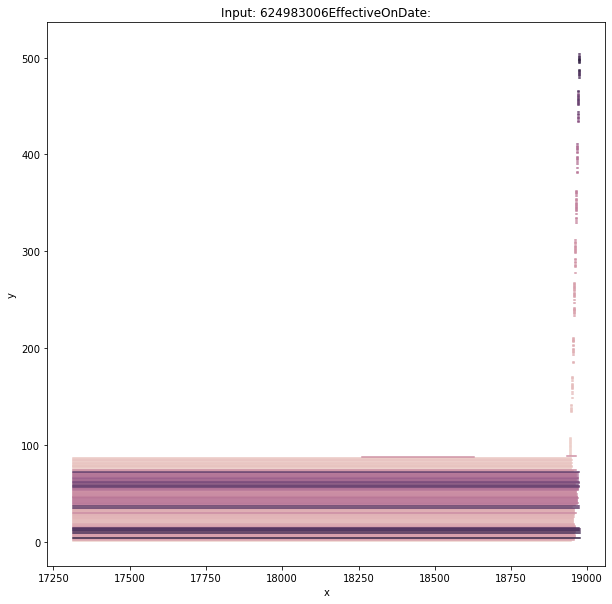

1636603200.0
18882.166666666668 18976.166666666668
6.168425681619461 3.375 4.666666666667879 60.0 60.0
1516


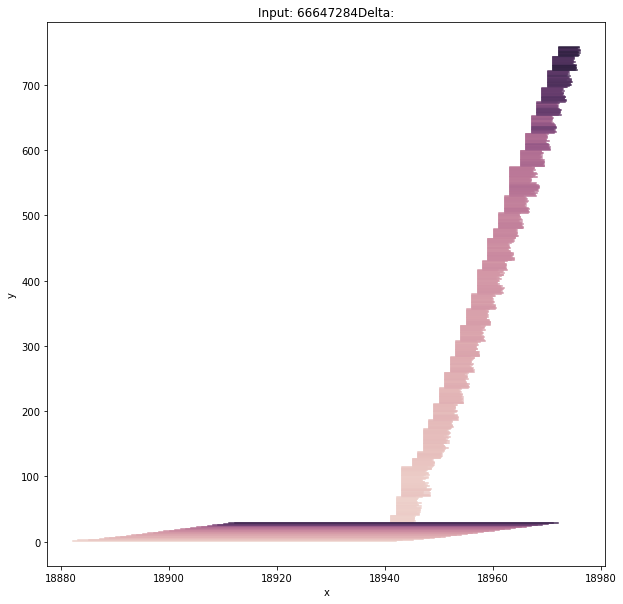

1636812000.0
18944.541666666668 18975.66665509259
0.04163357156883634 0.020833333332120674 0.041666666667879326 0.041666666667879326 0.041666666667879326
3016


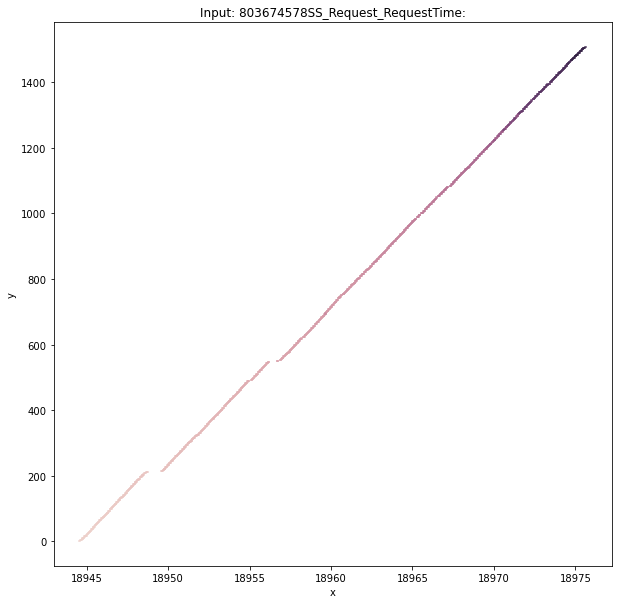

1636858800.0
18945.083333333332 18976.083333333332
0.04166666666666218 0.04166666666424135 0.041666666667879326 0.041666666667879326 0.041666666667879326
1082


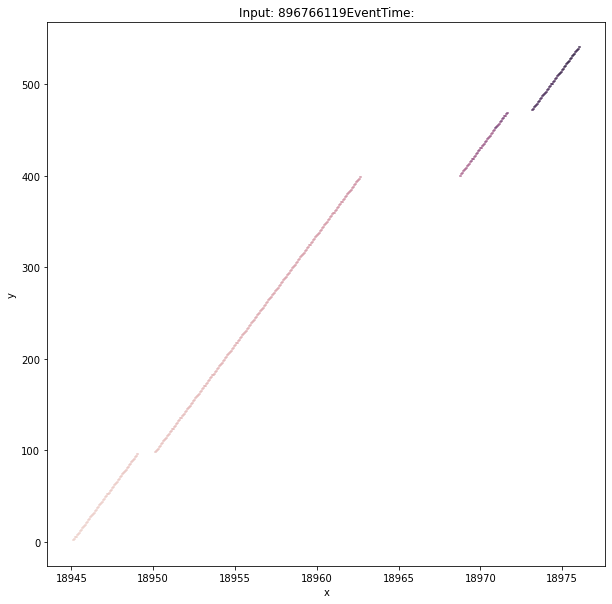

In [79]:
for ci, chosencol in enumerate(colranges["cont_column"].values):
    tmp2 = tmp[tmp.cont_column == chosencol]
    pdata = get_cont_xys_from_exprdf(tmp2)
    #print(len(pdata))
    #print(len(set(pdata["InputCardinality"])))
    #print(pdata["InputCardinality"].values)
    #print(pdata["InputCardinality"].describe())
    plot_cont_pdata(pdata)
#     if ci > 1:
#         break

In [77]:
print(len(allopdf))
print(len(set(allopdf["column"])))
allopinp = allopdf[allopdf["column"].isin(selinps)]
allopinp = allopinp[allopinp.dtype == "date"]
allopinp = allopinp[allopinp.optype.isin(["<", "<=", ">", ">="])]
print(len(allopinp))
print(len(set(allopinp["column"])))

2323654
47815
76736
42


In [78]:
inp = allopinp["input"].values[0]
inpdf = allopinp[allopinp.input == inp]

print(inpdf["column"].head(20))
#print(inpdf["column"])
print("num unique columns: ", len(set(inpdf["column"])))
print("num unique exprs: ", len(set(inpdf["exprhash"])))
print("total: ", len(inpdf["column"]))
#print(set(inpdf["column"]))
#inpdf

inpdf["constant"] /= 86400.0
minc = min(inpdf["constant"])
maxc = max(inpdf["constant"])

xvals = {}
xs = []
ys = []
ei = 0
pdata = defaultdict(list)
ranges = []

sp = 0.1
for eh in inpdf["exprhash"]:
    if eh in xvals:
        continue
    if random.random() > sp:
        continue
        
    ei += 1
    tmp = inpdf[inpdf.exprhash == eh]
    minv = minc
    maxv = maxc
    for _,row in tmp.iterrows():
        if "<" in row["op"]:
            maxv = row["constant"]
        elif ">" in row["op"]:
            minv = row["constant"]
    xvals[eh] = (minv, maxv)
    
    #ys.append((ei,ei))
    #xs.append((minv,maxv))
    #print("range: ", (maxv-minv) / 86400.0)
    
    ranges.append((maxv-minv))
    
    pdata["x"].append(minv)
    # adding minv to y so as to implicitly sort it by minimum x-values
    pdata["y"].append(ei)
    pdata["x"].append(maxv)
    pdata["y"].append(ei)
    
    pdata["expr"].append(ei)
    pdata["expr"].append(ei)

    pdata["yorder"].append(minv)
    pdata["yorder"].append(minv)
    
    #pdata["ycol"].append(remove_ints(str(row["column"])))
    #pdata["ycol"].append(remove_ints(str(row["column"])))

print(np.mean(ranges), np.min(ranges), np.percentile(ranges, 90), np.percentile(ranges,99), np.max(ranges))
pdata = pd.DataFrame(pdata)

216      -2141470936EffectiveOnDate:
217      -2141470936EffectiveOnDate:
511      -2141470936EffectiveOnDate:
512      -2141470936EffectiveOnDate:
5581     -2141470936EffectiveOnDate:
5582     -2141470936EffectiveOnDate:
11705    -2141470936EffectiveOnDate:
11706    -2141470936EffectiveOnDate:
15374    -2141470936EffectiveOnDate:
15375    -2141470936EffectiveOnDate:
15539    -2141470936EffectiveOnDate:
15540    -2141470936EffectiveOnDate:
23466    -2141470936EffectiveOnDate:
23467    -2141470936EffectiveOnDate:
25736    -2141470936EffectiveOnDate:
25737    -2141470936EffectiveOnDate:
30739    -2141470936EffectiveOnDate:
30740    -2141470936EffectiveOnDate:
34650    -2141470936EffectiveOnDate:
34651    -2141470936EffectiveOnDate:
Name: column, dtype: object
num unique columns:  1
num unique exprs:  236
total:  472
71.60144927536211 0.04166666666424135 0.9583333333321207 1636.1 1637.0


In [79]:
#pdata["x"] = pdata["x"] / 86400.0

pdata = pdata.sort_values(by="yorder")
#pdata1 = pdata[pdata["ycol"] == "StartDate:"]
#pdata2 = pdata[pdata["ycol"] != "StartDate:"]

<AxesSubplot:title={'center':'Input: -2141470936'}, xlabel='x', ylabel='y'>

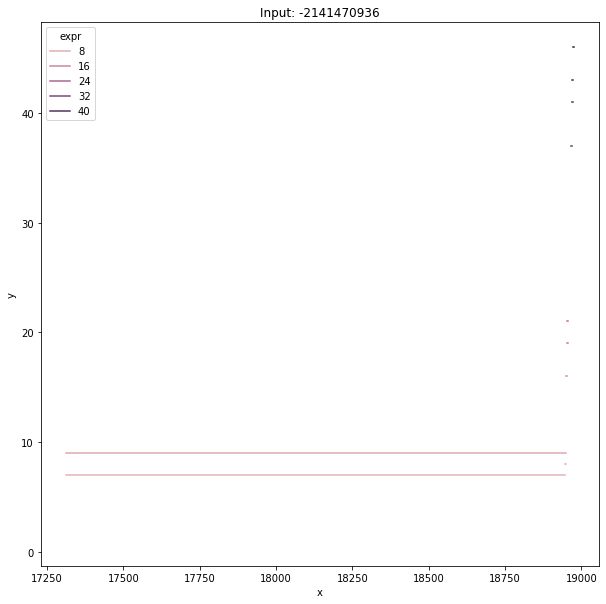

In [80]:
plt.figure(figsize=(10,10))
plt.title("Input: " + str(inp))

sns.lineplot(data=pdata, x="x", y="y", hue="expr")
#plt.xscale("log")
#plt.xlim(((min(pdata["x"]), max(pdata["x"]))))

# Like exploration

In [470]:
dflikes = df[df.like_ops == 1]
dflikes.groupby(["like_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

,like_dtype,count,mean,50%,90%
5,unknown,8253.0,23943.769438,0.374,3231.2832
6,url,2416.0,15206.887866,710.920,39823.1150
1,num,1383.0,3297.511559,18.071,2612.5582
4,short,1013.0,35993.849190,8.592,14354.6990
2,path,410.0,14653.756090,141.386,3670.5038
0,extension,56.0,124247.877964,36.365,28528.9090
3,serial,52.0,554.633846,3.794,316.8132


In [471]:
print(set(dflikes["like_dtype"]))
print(set(dflikes["like_kind"]))

{'unknown', 'url', 'path', 'serial', 'extension', 'num', 'short'}
{'ends', 'starts', 'contains', 'no%', 'multi%'}


In [472]:
# for _,row in dflikes.iterrows():
#     print(row["like_dtype"])

In [473]:
STATCOLS = ["ExclusiveTime", "like_lens", "InputCardinality", "RowCount", "Selectivity"]

curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
curdrops.append(tuple(["RowCount","mean"]))
curdrops.append(tuple(["Selectivity","mean"]))

In [474]:
dflikes.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')

In [51]:
pretty_print(dflikes.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

NameError: name 'dflikes' is not defined

In [476]:
pretty_print(dflikes.groupby(["num_likes"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("num_likes"), ascending=True).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [477]:
tmp = dflikes[dflikes["num_likes"] == 14]
tmp["FilterExpr"].values

array(['{"isComparison":false,"expOperator":"Or","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"Query.ToLower().Contains(\\"weather\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"Query.ToLower().Contains(\\"travel\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"Query.ToLower().Contains(\\"airport\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"Query.ToLower().Contains(\\"park\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"Query.ToLower().Contains(\\"flight\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"Query.ToLower().Contains(\\"vacation\\")","attribute":{"name":"

In [478]:
pretty_print(dflikes.groupby(["like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [479]:
pretty_print(dflikes.groupby(["like_kind"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))
#      drop(columns=curdrops).\
#      rename(columns={"like_lens":"Filter Length"}).\        
#      round(2))

In [480]:
tmp = dflikes[dflikes["unique_filter_cols"] == 0]
tmp["FilterExpr"].values

array([], dtype=object)

In [481]:
pretty_print(dflikes.groupby(["like_kind", "like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={}).\
     drop(columns=curdrops).round(2))

In [482]:
#dflikes.groupby("like_const")["jobid"].count().reset_index()["jobid"].describe(percentiles=[0.9,0.99])

# Summary runtime exploration

In [53]:
STATSTODROP = ["std", "min", "max", "99%"]

In [54]:
# HTML(df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

In [55]:
df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].sum().reset_index()\
    .sort_values(by="ExclusiveTime", ascending=False)

#df.groupby(["cont_ops"])["ExclusiveTime"].count().reset_index()

,cont_ops,discrete_ops,like_ops,ExclusiveTime
3,1,0,0,1.676605e+08
1,0,1,0,1.401580e+08
5,1,1,0,1.213680e+08
2,0,1,1,9.157473e+07
4,1,0,1,1.085177e+07
6,1,1,1,1.061366e+07
0,0,0,1,3.996567e+06


In [56]:
# #STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
# STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
#      drop(columns=curdrops).round(2))

In [57]:
# STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(df.groupby(["complex_ops","null_checks"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
#      drop(columns=curdrops).round(2))

In [58]:
STATCOLS = ["unique_filter_cols"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=(STATCOLS[0],"count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE",
                    "unique_filter_cols":"Num Filter Columns", "num_cols_all":"Total Columns",
                    "num_cols_sel":"Num Selected Columns", "num_pcols":"Num Partitioning Columns"}).round(2)
            )

In [60]:
df["unique_filter_cols"].describe(percentiles=[0.9,0.99])

count    3.078923e+06
mean     1.421620e+00
std      9.684918e-01
min      1.000000e+00
50%      1.000000e+00
90%      2.000000e+00
99%      5.000000e+00
max      2.400000e+01
Name: unique_filter_cols, dtype: float64

In [605]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["unique_filter_cols"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [498]:
HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["num_discrete_consts"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,550951.0,2.810010,2.817767,1.0,2.0,4.0,20.0,50.0
0,1,0,255845.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0,1,1,78560.0,2.441191,1.421030,1.0,2.0,4.0,6.0,43.0
1,0,1,5598.0,1.822258,1.757607,1.0,1.0,3.0,11.0,24.0
1,0,0,5411.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,1,1610.0,1.153416,0.553595,1.0,1.0,2.0,3.0,8.0
1,1,0,964.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# Continuous explorations

In [203]:
dfcont = df[df.cont_ops == 1]

In [204]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [205]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_dtype":"Continuous Data \\n Type"}).\
     drop(columns=curdrops).round(2))

In [208]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_type", "cont_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     #.sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_dtype":"Continuous Data \\n Type"}).\
     drop(columns=curdrops).round(2))

In [233]:
tmp = dfcont[dfcont.cont_type == ""]
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 100)
#tmp[["StageName", "FilterExpr"]]

# Exploring different stages

In [228]:
#tmp1 = dfcont[dfcont["StageName"].str.contains("SV1")]
tmp = df[df.StageName.isna()]
#tmp["FilterExpr"].head(5)

70976     {"isComparison":false,"expOperator":"And","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"=","attribute":{"name":"TenantId:12","dataType":"String"},"values":["@\"84df9e7f-e9f6-40af-b435-aaaaaaaaaaaa\""],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"!=","attribute":{"name":"CorrelationId:14","dataType":"Unknown"},"values":["null"],"children":[],"isSorted":false}],"isSorted":false}
77197                                                                                                                                                                                                                                                                                                                                    {"isComparison":true,"expOperator":"=","attribute":{"name":"Reason:12","dataType":"Int"},"values":["1"],"children":[],"isSorted":false}
84674                                                                 

In [232]:
df1 = df[~df.StageName.isna()]
sv1df = df1[df1.StageName.str.contains("SV1_")]
allsvdf = df1[~df1.StageName.str.contains("SV1_")]

In [234]:
sv1df

,jobid,HashTagInput,OperatorName,EstCardinality,InputCardinality,NormInputHashCode,RowCount,Selectivity,ExclusiveTime,StageName,VertexCount,FilterExpr,QError,like_ops,discrete_ops,discrete_eqs,discrete_noneqs,cont_ops,regex_ops,num_ops,unique_filter_cols,unique_filter_cols2,num_unique_ops,types_all,num_like_cols,num_likes,like_lens,like_dtype,like_kind,num_discrete_consts,discrete_type,in_ops,cont_dtype,cont_type,cont_range,cont_cols,db,cluster
62,5ba025a3-9796-40b3-bbdd-381bf17cda2c,5812517654611898468,PhyOp_Filter,3.859530e+07,4.824410e+07,1042378059,1,2.072792e-08,0.016,SV1_Extract_Partition,2,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""tenant_id:5"",""dataType"":""String""},""values"":[""\""a75b6bb0-6833-4b47-974c-ae7633b934c9\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""tenant_id:5"",""dataType"":""String""},""values"":[""\""e0efbca7-eb55-470c-8340-fe0995acf839\""""],""children"":[],""isSorted"":false}],""isSorted"":false}",3.859530e+07,0,1,1,0,0,0,2,1,1,1,=,0,0,0,,,2,string,0,,,-1.0,0,1922905,cosmos14
269,683a3f79-8464-4e5e-8e13-082b221ab7c3,10512238656281449890,PhyOp_Filter,7.175100e+06,8.968870e+06,-1128880926,6884784,7.676312e-01,0.314,SV1_Extract_Split,2,"{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":"""",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249408738427387904L /* 2021-11-12T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false}",1.042168e+00,0,1,1,0,0,0,1,1,1,1,=,0,0,0,,,1,num,0,,,-1.0,0,4924027,cosmos14
304,1faa3044-c3f5-4857-98c2-c800a3a90285,14951777887314337454,PhyOp_Filter,2.450500e+08,7.478320e+08,-593398183,175430196,2.345850e-01,15.129,SV1_Extract,322,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""StorefrontGroupName:3"",""dataType"":""String""},""values"":[""\""Xbox Store\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""ProductGroupName:16"",""dataType"":""String""},""values"":[""\""App & Game\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""ProductTypeAltName:19"",""dataType"":""String""},""values"":[""\""Game\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""MarketCode:29"",""dataType"":""String""},""values"":[""\""US\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""!="",""attribute"":{""name"":""PurchaserPuid:1"",""dataType"":""String""},""values"":[""\""0\""""],""children"":[],""isSorted"":false}],""isSorted"":false}",1.396852e+00,0,1,1,1,0,0,5,5,5,2,"=,=,=,=,=",0,0,0,,,5,string,0,,,-1.0,0,021142,cosmos14
346,6544d2d5-dd95-4113-87c1-db08341b0a07,17766294295265187899,PhyOp_Filter,6.398400e+01,7.998000e+01,-1923988055,48,6.001500e-01,0.000,SV1_Extract_Partition,2,"{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""DateUtc:0"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(-8585672392854775808L /* 2021-10-16T00:00:00.0000000-07:00 */)""],""children"":[],""isSorted"":false}",1.333000e+00,0,0,0,0,1,0,1,1,1,1,cont,0,0,0,,,0,,0,date,gt,-1.0,1,553812,cosmos14
369,ceaaf3b6-0970-4bfb-a326-db30e1388440,5812517654611898468,PhyOp_Filter,3.859530e+07,4.824410e+07,1042378059,0,0.000000e+00,0.000,SV1_Extract_Partition,2,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""tenant_id:5"",""dataType"":""String""},""values"":[""\""26071618-211d-482f-b7e8-a7840e43e7f3\""""],""children"":[],""isSorted"":false},

In [235]:
allsvdf

,jobid,HashTagInput,OperatorName,EstCardinality,InputCardinality,NormInputHashCode,RowCount,Selectivity,ExclusiveTime,StageName,VertexCount,FilterExpr,QError,like_ops,discrete_ops,discrete_eqs,discrete_noneqs,cont_ops,regex_ops,num_ops,unique_filter_cols,unique_filter_cols2,num_unique_ops,types_all,num_like_cols,num_likes,like_lens,like_dtype,like_kind,num_discrete_consts,discrete_type,in_ops,cont_dtype,cont_type,cont_range,cont_cols,db,cluster
0,5ca6497f-b5a4-49d3-b9d5-03dccf5e99b6,8662125607066412010,PhyOp_Filter,2.061550e+08,5.033079e+08,825682202,169455743,3.366840e-01,32.200,SV7_Extract_Split,60,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""RequestType:731"",""dataType"":""String""},""values"":[""\""AccountClose\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":"">"",""attribute"":{""name"":""RequestId:730"",""dataType"":""Long""},""values"":[""2021102609000000000L""],""children"":[],""isSorted"":false}],""isSorted"":false}",1.216571e+00,0,1,1,0,1,0,2,2,2,2,"=,cont",0,0,0,,,1,string,0,int,gt,-1.0,1,4333842,cosmos14
1,5ca6497f-b5a4-49d3-b9d5-03dccf5e99b6,8662125607066412010,PhyOp_Filter,2.061550e+08,5.033079e+08,825682202,169455743,3.366840e-01,32.200,SV7_Extract_Split,60,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""RequestType:1073"",""dataType"":""String""},""values"":[""\""AccountClose\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":"">"",""attribute"":{""name"":""RequestId:1072"",""dataType"":""Long""},""values"":[""2021102609000000000L""],""children"":[],""isSorted"":false}],""isSorted"":false}",1.216571e+00,0,1,1,0,1,0,2,2,2,2,"=,cont",0,0,0,,,1,string,0,int,gt,-1.0,1,4333842,cosmos14
2,a72b0d6d-67eb-4389-81be-3d79f3e546d7,4765964926349018101,PhyOp_Filter,2.051620e+08,5.008849e+08,825682202,169455743,3.383127e-01,30.622,SV7_Extract_Split,60,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""RequestType:938"",""dataType"":""String""},""values"":[""\""AccountClose\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":"">"",""attribute"":{""name"":""RequestId:937"",""dataType"":""Long""},""values"":[""2021102609000000000L""],""children"":[],""isSorted"":false}],""isSorted"":false}",1.210711e+00,0,1,1,0,1,0,2,2,2,2,"=,cont",0,0,0,,,1,string,0,int,gt,-1.0,1,4333842,cosmos14
3,692037a6-db1c-4ee6-9226-8380e7ade305,5334623705384220162,PhyOp_Filter,2.373510e+07,3.708610e+07,887131469,19672147,5.304453e-01,1.705,SV2_Extract_Partition,4,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""Date:362"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249386274427387904L /* 2021-10-17T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""<="",""attribute"":{""name"":""Date:362"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249409602427387904L /* 2021-11-13T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false}],""isSorted"":false}",1.206533e+00,0,0,0,0,1,0,2,1,1,2,cont,0,0,0,,,0,,0,date,range,2332800.0,1,19422387,cosmos14
4,692037a6-db1c-4ee6-9226-8380e7ade305,5334623705384220162,PhyOp_Filter,2.449540e+07,3.827410e+07,887131469,20329147,5.311463e-01,1.733,SV3_Extract_Partition,4,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""Dat

In [502]:
# HTML(dfcont.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [503]:
# HTML(df.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [504]:
# HTML(dfcont.groupby(["cont_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [505]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [506]:
# HTML(dfcont.groupby(["cont_dtype", "cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [507]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [508]:
# # HTML(df.groupby(["cont_range"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# #print(set(df["cont_range"]))

# HTML(dfcont.groupby(["cont_dtype"])["cont_range"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [206]:
HTML(dfcont.groupby(["cont_cols"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_cols,count,mean,std,min,50%,90%,99%,max
1,249539.0,80.191268,2130.216556,0.000,0.1550,7.2080,2082.68870,659719.431
2,168687.0,18.014113,1062.911506,0.000,0.0160,0.0630,0.14000,110761.748
0,16354.0,3163.077232,31199.141515,0.000,0.0150,100.9776,130251.04475,1003820.238
3,169.0,31.469651,58.415798,0.000,3.5900,126.3300,139.53604,451.973
5,24.0,10.009125,11.963994,0.000,4.5855,18.3833,45.23077,52.200
6,5.0,0.097400,0.120730,0.000,0.0320,0.2324,0.25004,0.252
4,4.0,3.338750,6.677500,0.000,0.0000,9.3485,12.95435,13.355
16,1.0,0.126000,NaN,0.126,0.1260,0.1260,0.12600,0.126


# Surprising: among range date queries, not so many queries of 1-day to 1-week as you'd expect?

In [510]:
dfr = df[df.cont_range > 0.0]
dfr = dfr[df.cont_dtype == "date"]
dfr["cont_range_days"] = dfr.apply(lambda x: x["cont_range"] / 86400 ,axis=1)

HTML(dfr.groupby(["cont_dtype"])["cont_range_days"].describe(percentiles=[0.25, 0.40,
                            0.6, 0.75, 0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

/tmp/ipykernel_2041059/3061431282.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfr = dfr[df.cont_dtype == "date"]


cont_dtype,count,mean,std,min,25%,40%,50%,60%,75%,90%,99%,max
date,39852.0,61130.656142,467791.404089,0.003472,0.041667,0.041667,0.458333,1.0,42.041667,1418.0,3.652059e+06,3.652059e+06


# multi-column explorations

In [511]:
# HTML(df.groupby(["discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [512]:
# HTML(df.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [43]:
#df2 = df[df["types_all"].count(",") <= 2]
#df2
types_all = set(df["types_all"].values)
new_types_all = set()
for t in types_all:
    #t2 = t.replace("null,", "")
    if "null" in t:
        continue
    if t.count(",") == 1:
        new_types_all.add(t)

df2 = df[df.types_all.isin(new_types_all)]
# HTML(df2.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).round(2).to_html(index=False))

STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))
curdrops.append(tuple(["QError","mean"]))

pretty_print(df2.groupby(["types_all"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

NameError: name 'STATSTODROP' is not defined

In [514]:
# HTML(df.groupby(["types_all"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

# Filter by templated query or not

In [515]:
# import copy
# dfall = copy.deepcopy(df)

In [516]:
#print(df.keys())

In [517]:
# print(len(set(df["HashTagNonStrict"])))
# dftmp = df.groupby("HashTagNonStrict").count()["jobid"].reset_index()
# #print(len(dftmp))
# #print(dftmp.head(5))
# df = dfall
# THRESH = 10
# dftmp1 = dftmp[dftmp["jobid"] <= THRESH]
# dftmp2 = dftmp[dftmp["jobid"] > THRESH]

# repeating_tmps = dftmp2["HashTagNonStrict"].values
# not_repeating_tmps = dftmp1["HashTagNonStrict"].values
# print(len(repeating_tmps), len(not_repeating_tmps))

# import copy

# dfrep = df[df["HashTagNonStrict"].isin(repeating_tmps)]
# dfnonrep = df[df["HashTagNonStrict"].isin(not_repeating_tmps)]

In [518]:
#df = dfall

In [519]:
#HTML(dfrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [520]:
#df.keys()

In [521]:
#HTML(dfnonrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [523]:
HTML(df[["like_ops", "discrete_ops", "cont_ops", "in_ops"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,like_ops,discrete_ops,cont_ops,in_ops
count,898939.000000,898939.000000,898939.000000,898939.0
mean,0.015110,0.708301,0.374863,0.0
std,0.121991,0.454545,0.484088,0.0
min,0.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,0.000000,0.0
90%,0.000000,1.000000,1.000000,0.0
99%,1.000000,1.000000,1.000000,0.0
max,1.000000,1.000000,1.000000,0.0


In [524]:
HTML(df[["like_ops", "discrete_ops", 
         #"discrete_eqs", "discrete_noneqs", 
         #"in_ops",
         #"complex_ops",
         "cont_ops", 
        # "cont_dates", "cont_others"
        ]].\
     mean().reset_index().to_html(index=False))

index,0
like_ops,0.015110
discrete_ops,0.708301
cont_ops,0.374863


# More discrete exploration

In [525]:
dfdisc = df[df.discrete_ops == 1]
dfdisc = dfdisc[dfdisc.discrete_type != ""]
# print(len(df), len(dfdisc))
# #HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
# #     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type", "in_ops"]).count()["jobid"].\
#      reset_index().to_html(index=False))

In [526]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [527]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_eqs"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [528]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["like_ops", "discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [529]:
HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,326.0,0.019289,0.103608,0.0,0.000233,0.014665,0.46650,1.0
0,null,35175.0,0.223472,0.330909,0.0,0.086194,1.000000,1.00000,1.0
0,num,15366.0,0.236947,0.351232,0.0,0.062192,1.000000,1.00000,1.0
0,string,11609.0,0.302385,0.409404,0.0,0.086230,1.000000,1.00000,1.0
1,bool,15295.0,0.163526,0.305248,0.0,0.002700,0.890595,1.00000,1.0
1,null,48493.0,0.049231,0.093179,0.0,0.025474,0.126606,0.41362,1.0
1,num,267801.0,0.147695,0.289486,0.0,0.002158,0.655361,1.00000,1.0
1,string,242654.0,0.386194,0.317741,0.0,0.370947,0.982801,1.00000,1.0


### Note: discrete_eq + boolean ----> much higher runtime than any other group;
### Note2: actually, like_ops + bool ----> much higher runtimes

In [530]:
HTML(dfdisc.groupby(["like_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,14753.0,3579.435860,191793.544729,0.0,10.3490,805.7138,2.953479e+04,22652121.093
0,null,82590.0,2788.442404,270855.258332,0.0,4.3730,178.1798,3.226698e+03,54205161.074
0,num,280189.0,340.140274,27056.674870,0.0,0.0160,7.3582,9.311006e+02,11220763.317
0,string,251979.0,569.955460,35149.702009,0.0,0.0000,1.3380,2.534676e+03,12756790.626
1,bool,868.0,67209.232053,290324.589706,0.0,7.7615,20.9475,1.727305e+06,2141816.430
1,null,1078.0,29606.077788,166084.079073,0.0,1223.4645,2792.6713,1.099236e+06,2232787.189
1,num,2978.0,8306.661556,123346.165979,0.0,0.0780,30853.7935,6.512889e+04,6692144.805
1,string,2284.0,24329.546019,621155.485351,0.0,0.0775,7699.4155,1.714466e+05,28366368.595


In [531]:
HTML(dfdisc.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,550951.0,848.578226,111942.603332,0.0,0.000,10.4210,2073.83400,54205161.074
0,1,1,78560.0,693.740114,52253.615484,0.0,2.889,46.7720,3371.16133,14056811.682
1,0,1,5598.0,25390.886802,425124.818798,0.0,0.063,3678.8078,680523.68563,28366368.595
1,1,1,1610.0,17652.610050,110646.857636,0.0,420.916,31204.6090,296363.16621,1200994.570


In [532]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# Like Ops when discrete_ops = 0

In [533]:
# HTML(dfdisc.groupby(["unique_filter_cols", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [534]:
# HTML(dfdisc.groupby(["num_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# ComplexOps ---> More runtime

In [535]:
# HTML(df.groupby(["complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [536]:
# HTML(df.groupby(["complex_ops"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# Extreme cases

In [537]:
# dfext = df[df["ExclusiveTime"] == 1546313.691]
# print(dfext.keys())
# print(dfext[FILTER_FIELD].values[0])
# dfext[["OperatorName", "InputCardinality", "VertexCount", "RowCount", "Selectivity", "num_ops", 
#       "num_unique_ops", "unique_filter_cols", "num_cols_all", "num_pcols", "like_ops", 
#       "cont_ops", "cont_dates", "udf_ops"]]

# Top few execution time ones are just String.isNullOrEmpty;
# Next is = true + LIKE predicate

In [538]:
# dftmp = df.sort_values(by="ExclusiveTime", ascending=False)
# NUM=50
# print(dftmp["ExclusiveTime"].head(NUM))
# for i in range(NUM):
#     print(dftmp[FILTER_FIELD].values[i])

In [539]:
df["VertexCount"].describe(percentiles=[0.9, 0.99])

count    898939.000000
mean        279.150707
std        3925.315874
min           0.000000
50%           4.000000
90%         443.000000
99%        4096.000000
max      962731.000000
Name: VertexCount, dtype: float64

In [540]:
# corr = df.corr().abs()
# corr["InclusiveTime"].reset_index().sort_values(by="InclusiveTime", ascending=False)\
#     .rename(columns={"InclusiveTime":"Correlation w/ Runtime"})

# Exploring likes

In [541]:
df.groupby("like_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,885356.0,1543.051332,151421.224984,0.0,0.016,18.080,2768.31120,5.420516e+07
1,13583.0,21229.828469,390017.279351,0.0,3.297,4826.281,490071.48912,2.836637e+07


In [542]:
#df.groupby("discrete_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

In [543]:
df.groupby("like_ops")["Selectivity"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,885356.0,0.218984,0.316127,0.0,0.040984,0.808678,1.0,1.0
1,13583.0,0.146011,0.283853,0.0,0.005040,0.516697,1.0,1.0


In [544]:
df.groupby("like_ops")["RowCount"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,885356.0,8.187339e+08,5.211719e+10,0.0,10042.5,4.215702e+07,9.669200e+09,1.300820e+13
1,13583.0,2.205251e+09,2.217177e+10,0.0,892307.0,1.600470e+09,3.350214e+10,1.501715e+12


In [545]:
pretty_print(
    dflikes.groupby("like_ops")[["like_lens"]].describe(percentiles=[0.7, 0.9, 0.99]).\
    reset_index().\
    rename(columns={"like_lens": "Length of like filter", "like_ops":"LIKE"})
)

In [546]:
dflikes = df[df.like_ops == 1]
dflikes = dflikes.sort_values(by="like_lens")
HTML(dflikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExpr,ExclusiveTime,Selectivity
270239,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""SS_Market:2093"",""dataType"":""String""},""values"":[""\""en-US\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""SS_Vertical:2088"",""dataType"":""String""},""values"":[""\""web\""""],""children"":[],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""ANIDFilter.ExistANID(\""LatestANIDBlacklist.log.gz\"", SS_User_Anid, SS_Log_Date)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":true,""expOperator"":""\""en-in\"".Split(new char[] {','}).Contains(SS_Market.ToLower())"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",23.534,0.000000e+00
52840,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsAADSignin:181"",""dataType"":""Bool""},""values"":[""true""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""RequestTime.ToUniversalTime().Date >= System.DateTime.FromBinary(637291584000000000L) && RequestTime.ToUniversalTime().Date <= System.DateTime.FromBinary(637712352000000000L)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""String.IsNullOrEmpty(AnaheimId)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":false,""expOperator"":null,""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""String.IsNullOrWhiteSpace(PageName)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false},{""isComparison"":true,""expOperator"":""\""page.unspecified,page.video.results.detailasync,page.home.initialize\"".Split(',').Contains(PageName.ToLower())"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",945.746,0.000000e+00
21282,0,"{""isComparison"":true,""expOperator"":""@\""en,fr,de,it,nl,da,es,no,fi,se\"".Contains(LanguageCode.ToLower())"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",2.136,1.368447e-01
817627,0,"{""isComparison"":true,""expOperator"":""!string.IsNullOrEmpty(Entity.masterId) && Entity.masterId.Length >= 3 && Entity.FeedEntityProcessing != null && @\""3400,470\"".Split(',').Contains(Entity.FeedEntityProcessing.FeedID.ToString())"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",73766.683,5.440243e-07
83470,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""!="",""attribute"":{""name"":""Title:57"",""dataType"":""Unknown""},""values"":[""null""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""!="",""attribute"":{""name"":""Body:58"",""dataType"":""Unknown""},""values"":[""null""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""CleanEntityName.Split(' ').Where(x => !CleanTitle.Contains(x)).Any()"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isCompa

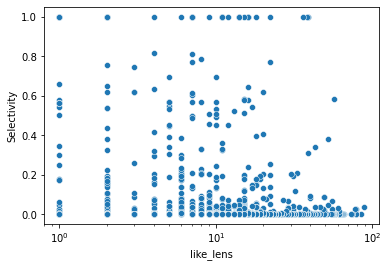

In [547]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="Selectivity")
plt.xscale("log")
#plt.yscale("log")

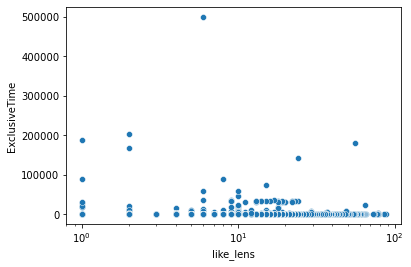

In [550]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="ExclusiveTime")
plt.xscale("log")
#plt.yscale("log")
#plt.ylim([0,0.1e4])

In [551]:
#df.groupby("like_ops")["ExclusiveTime"].sum()

In [552]:
dfonlylikes = df[df.like_ops == 1]
dfonlylikes = dfonlylikes[dfonlylikes.discrete_ops == 0]
dfonlylikes = dfonlylikes[dfonlylikes.cont_ops == 0]
#dfonlylikes = dfonlylikes[dfonlylikes.complex_ops == 0]
HTML(dfonlylikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [553]:
dfonlylikes.groupby("like_ops")["like_lens"].describe(percentiles=[0.7, 0.9, 0.99])

,count,mean,std,min,50%,70%,90%,99%,max
like_ops,,,,,,,,,
1,5411.0,15.914988,17.148406,0.0,9.0,18.0,42.0,71.9,174.0


In [555]:
#dfonlylikes = dfonlylikes.sort_values(by="like_lens")
dfonlylikes = dfonlylikes.sort_values(by="like_lens", ascending=False)
HTML(dfonlylikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExpr,ExclusiveTime,Selectivity
125554,174,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""GoodUrl.StartsWith(\""https://www.tiktok.com/tag/fyp?\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""GoodUrl.StartsWith(\""https://tw.bid.yahoo.com/item/41-%E4%BB%A3%E8%B3%BC%E6%9C%89%E7%8F%BE%E8%B2%A8-%E5%90%88%E8%B3%BC%E5%85%8D%E9%81%8B%E8%B2%BB-Y%E6%8B%8D%E6%9C%80%E4%BD%8E%E5%83%B9-%E6%97%A5%E6%9C%AC%E8%A8%AD%E8%A8%88%E5%93%81%E7%89%8C-Sh-100549797621/\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",46626.598,1.075153e-07
690993,169,"{""isComparison"":true,""expOperator"":""ALL(wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/\"") == false || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-cn/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-tw/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-hk/\"") == true, wikiPageUrl.StartsWith(\""http://zh-yue.wikipedia.org/wiki/\"") == false, wikiPageUrl.StartsWith(\""http://zh-min-nan.wikipedia.org/wiki/\"") == false)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",1.439,7.876271e-01
793038,169,"{""isComparison"":true,""expOperator"":""ALL(wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/\"") == false || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-cn/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-tw/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-hk/\"") == true, wikiPageUrl.StartsWith(\""http://zh-yue.wikipedia.org/wiki/\"") == false, wikiPageUrl.StartsWith(\""http://zh-min-nan.wikipedia.org/wiki/\"") == false)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",1.107,7.876390e-01
247589,169,"{""isComparison"":true,""expOperator"":""ALL(wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/\"") == false || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-cn/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-tw/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-hk/\"") == true, wikiPageUrl.StartsWith(\""http://zh-yue.wikipedia.org/wiki/\"") == false, wikiPageUrl.StartsWith(\""http://zh-min-nan.wikipedia.org/wiki/\"") == false)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",1.185,7.876313e-01
247155,169,"{""isComparison"":true,""expOperator"":""ALL(wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/\"") == false || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-cn/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-tw/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-hk/\"") == true, wikiPageUrl.StartsWith(\""http://zh-yue.wikipedia.org/wiki/\"") == false, wikiPageUrl.StartsWith(\""http://zh-min-nan.wikipedia.org/wiki/\"") == false)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",1.208,7.876335e-01
197144,169,"{""isComparison"":true,""expOperator"":""ALL(wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/\"") == false || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-cn/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-tw/\"") == true || wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/zh-hk/\"") == true, wikiPageUrl.StartsWith(\""http://zh-yue.wikipedia.org/wiki/\"") == false, wikiPageUrl.StartsWith(\""http://zh-min-nan.wikipedia.org/wiki/\"") == false)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",0.911,7.876377e-01
734484,169,"{""isComparison"":true,""expOperator"":""ALL(wikiPageUrl.StartsWith(\""http://zh.wikipedia.org/\"") == false 

In [556]:
dflikes = df[df.like_ops == 1]
HTML(dflikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [557]:
dflikedisc = df[df.like_ops == 1]
dflikedisc = dflikedisc[dflikedisc.discrete_ops == 1]
HTML(dflikedisc.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

# Correlations

In [560]:
print(df.keys())
tmpdf = df[["OperatorName", "EstCardinality", "InputCardinality", 
            #"PartitioningColumn",
           #'SortColumn', 
       #'InclusiveTime', 
            'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       #'num_cols_all', 'num_cols_sel', 'num_pcols', 
       'like_ops', 'discrete_ops',
       'discrete_eqs', 'discrete_noneqs', 'discrete_type', 
        #'null_checks',
       'cont_ops', 
       #'cont_dates', 'cont_others', 'complex_ops',
       #'complex_ops_num', 'udf_ops', 'in_ops', 'equal_dates',
       'num_discrete_consts', 
            #'discrete_types_all', 
            'cont_type', 'cont_dtype',
       'cont_range', 'types_all', 'like_lens']]
corr = tmpdf.corr()

HTML(corr.round(2).to_html())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')


,EstCardinality,InputCardinality,ExclusiveTime,VertexCount,RowCount,Selectivity,num_ops,num_unique_ops,unique_filter_cols,like_ops,discrete_ops,discrete_eqs,discrete_noneqs,cont_ops,num_discrete_consts,cont_range,like_lens
EstCardinality,1.0,-0.00,-0.00,-0.00,-0.00,-0.00,NaN,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
InputCardinality,-0.0,1.00,-0.00,-0.00,-0.00,-0.00,NaN,-0.00,-0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.00,-0.00,-0.00
ExclusiveTime,-0.0,-0.00,1.00,0.23,0.71,0.01,NaN,-0.00,-0.00,0.02,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.01
VertexCount,-0.0,-0.00,0.23,1.00,0.24,-0.02,NaN,0.03,0.00,0.02,-0.00,-0.01,0.01,0.02,-0.02,-0.00,0.01
RowCount,-0.0,-0.00,0.71,0.24,1.00,0.02,NaN,-0.00,-0.00,0.00,-0.01,-0.01,0.00,0.01,-0.01,-0.00,0.00
Selectivity,-0.0,-0.00,0.01,-0.02,0.02,1.00,NaN,-0.19,-0.18,-0.03,0.11,0.10,-0.10,-0.19,0.16,-0.02,-0.01
num_ops,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_unique_ops,-0.0,-0.00,-0.00,0.03,-0.00,-0.19,NaN,1.00,0.55,0.11,-0.09,-0.12,0.46,0.53,-0.03,0.03,0.09
unique_filter_cols,0.0,-0.00,-0.00,0.00,-0.00,-0.18,NaN,0.55,1.00,0.07,0.23,0.22,0.52,0.08,0.44,0.01,0.04
like_ops,-0.0,-0.00,0.02,0.02,0.00,-0.03,NaN,0.11,0.07,1.00,-0.05,-0.07,0.02,-0.05,-0.05,-0.00,0.72


# why is this an extreme outlier?

In [561]:
dflikebool = df[df.like_ops == 1]
dflikebool = dflikebool[dflikebool.discrete_type == "bool"]
HTML(dflikebool.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [562]:
#dflikebool[FILTER_FIELD].values[5]

# Continuous exploration

In [564]:
dfcont = df[df.cont_ops == 1]
print(len(df), len(dfcont))
#HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
#     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"]).count()["jobid"].\
#      reset_index().to_html(index=False))

898939 336979


### Note: continuous operators seem to typically have higher selectivity than discrete operators
### Note: 90th percentile difference b/w date vs nodate

In [566]:
# HTML(dfcont.groupby(["cont_dates"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [568]:
# HTML(dfcont.groupby(["cont_dates"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [569]:
HTML(dfcont.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
gt,133939.0,738.679632,2.549898e+04,0.0,0.046,31.3080,815.27428,3745854.863
other,82251.0,414.881945,1.133747e+04,0.0,0.032,5.3140,2920.78650,1686346.483
lt,61478.0,1486.398831,1.040326e+05,0.0,0.031,36.6921,3003.01028,12843815.493
range,42436.0,619.417081,8.777987e+03,0.0,1.405,448.1005,8613.95175,671786.524
,12101.0,55804.407501,1.020989e+06,0.0,0.032,135.6970,124797.29800,27010152.814
discont,4774.0,841.894539,1.327887e+04,0.0,1.969,245.2105,10986.70954,831970.074


In [571]:
dfnodate = dfcont[dfcont.cont_dtype != "date"]
HTML(dfnodate.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
other,82251.0,0.089542,0.136272,0.0,0.102345,0.106982,1.000000,1.0
gt,67677.0,0.047039,0.141248,0.0,0.014950,0.069296,1.000000,1.0
lt,36972.0,0.296368,0.363217,0.0,0.094114,1.000000,1.000000,1.0
,12101.0,0.200697,0.342286,0.0,0.003915,1.000000,1.000000,1.0
discont,3918.0,0.049917,0.146366,0.0,0.000669,0.058107,0.948766,1.0
range,3026.0,0.068607,0.197222,0.0,0.002910,0.141409,1.000000,1.0


In [572]:
HTML(dfnodate.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
,12101.0,55804.407501,1.020989e+06,0.0,0.032,135.6970,124797.29800,27010152.814
discont,3918.0,1025.423585,1.465177e+04,0.0,2.455,529.3331,11662.96502,831970.074
gt,67677.0,393.698751,2.074879e+04,0.0,3.450,34.9514,1745.34396,3745854.863
lt,36972.0,2418.360193,1.341347e+05,0.0,0.107,113.2257,5542.67045,12843815.493
other,82251.0,414.881945,1.133747e+04,0.0,0.032,5.3140,2920.78650,1686346.483
range,3026.0,1606.216196,2.231007e+04,0.0,40.689,234.0800,12065.28825,671786.524


# Continuous and discrete ops together

## Note: mostly date (ranges) + discrete ops; ---> why there are so many of these after duplication, since date ranges keep changing but discrete predicates don't change

## TODO: when do the discrete predicates change in cases with date sliding windows?

## TODO: are there sliding windows for non-date variety as well? (prolly not?)

In [578]:
dfboth = df[df.cont_ops == 1]
dfboth = dfboth[dfboth.discrete_ops == 1]
dfboth = dfboth[dfboth.like_ops == 0]
#dfboth = dfboth[dfboth.complex_ops == 0]
print(len(df), len(dfboth))
HTML(dfboth.groupby(["cont_dtype", "discrete_type"]).count()["jobid"].\
     reset_index().to_html(index=False))

898939 78560


cont_dtype,discrete_type,jobid
,bool,33
,null,2841
,num,383
,string,2021
date,bool,215
date,null,3519
date,num,3136
date,string,17541
date2,bool,2
date2,null,20


In [581]:
# HTML(dfboth.groupby(["cont_dtype", "discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

#### Note: cont_date+discrete_eq+bool ---> higher runtime; unclear why not in cont_others;

In [584]:
# HTML(dfboth.groupby(["cont_dtype", "discrete_eqs", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# End exploring further discrete/continuous further #

In [585]:
HTML(df[["num_ops", "num_unique_ops", "unique_filter_cols", 
         #"num_pcols",
        "num_discrete_consts"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,num_ops,num_unique_ops,unique_filter_cols,num_discrete_consts
count,898939.0,898939.000000,898939.000000,898939.000000
mean,8.0,1.326735,1.521707,1.948982
std,0.0,0.614172,1.156035,2.578236
min,8.0,1.000000,1.000000,0.000000
50%,8.0,1.000000,1.000000,1.000000
90%,8.0,2.000000,3.000000,4.000000
99%,8.0,3.000000,7.000000,12.000000
max,8.0,5.000000,13.000000,50.000000


In [586]:
HTML(df[["Selectivity", "InputCardinality"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,Selectivity,InputCardinality
count,898939.000000,8.989390e+05
mean,0.217881,3.467313e+30
std,0.315790,1.013137e+33
min,0.000000,1.000000e+00
50%,0.038858,3.083080e+06
90%,0.807797,9.399730e+09
99%,1.000000,2.057315e+12
max,1.000000,3.032076e+35


In [589]:
# df2 = df.sample(frac=0.0001)
# def to_set(x):
#     return set(x)
    
#df = df.groupby('col1')['col2'].agg(size= len, set= lambda x: set(x))
#df2 = df2.groupby(INP_FIELD)["num_ops"].agg(size= len, set= lambda x: set(x))

# Per Input-Column-Constant df

In [590]:
constdata = defaultdict(list)


In [591]:
## Distribution of discrete filters
# dftmp = df[df["discrete_ops"] == 1]
# HTML(dftmp[["num_cols_all", "unique_filter_cols","num_discrete_consts"]].\
#      describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [612]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')

In [617]:
print(len(set(allopdf["input"])))

22369


In [624]:
allopdf["column2"] = allopdf.apply(lambda x: x["column"][:x["column"].find(":")] ,axis=1)

In [629]:
inps = allopdf.groupby("input")["column"].nunique().reset_index()
inps2 = allopdf.groupby("input")["column2"].nunique().reset_index()
inps["column"].describe(percentiles=[0.9, 0.99])

count     22369.000000
mean         32.957620
std        1099.632525
min           1.000000
50%           2.000000
90%           9.000000
99%         186.000000
max      149832.000000
Name: column, dtype: float64

In [633]:
inps2["column2"].describe(percentiles=[0.9, 0.99])

count    22369.000000
mean         2.214493
std          3.293446
min          1.000000
50%          1.000000
90%          4.000000
99%         13.000000
max        191.000000
Name: column2, dtype: float64

In [695]:
tmp = allopdf[allopdf.input == -2059623338]
print(set(tmp["column2"]))
#tmp = tmp[tmp["column2"] == ("AdType")]
tmp = tmp[tmp["column2"] == ("NUM")]
print(set(tmp["column2"]))
#print(set(tmp["column"]))
print(set(tmp["constant"]))

{'AdId', 'ImpressionFraudQualityBand', 'ClickFraudQualityBand', 'TG', 'Muid', 'NUM', 'PClick', 'TagId', 'AdType'}
{'NUM'}
{'100000'}


In [638]:
discopdf = allopdf[allopdf["op"].isin(["=", "!="])]

In [667]:
#### we can get these from allopvals
# inp_stats["AllFilterColumns"] = num_unique_filter_cols

fcols1 = allopdf.groupby("input")["column"].nunique().reset_index()\
    .rename(columns={"column":"AllFilterColumns", "input":INP_FIELD})
fcols2 = allopdf.groupby("input")["column2"].nunique().reset_index()\
    .rename(columns={"column2":"AllFilterColumns", "input":INP_FIELD})

# inp_stats["#DiscreteRepeatsMax"] = maxrepeats
totaltimes = df.groupby(INP_FIELD)["ExclusiveTime"].sum().reset_index()

# inp_stats["#DiscreteConstants"] = numconstants
fconsts = discopdf.groupby("input")["constant"].nunique().reset_index()\
    .rename(columns={"constant":"#DiscreteConstants", "input":INP_FIELD})

# inp_stats["#DiscreteRepeatsStd"] = repeatstds
#inp_stats["#UniquePredicates"] = num_unique_in_consts
fpreds = discopdf.groupby("input")["constant"].nunique().reset_index()\
    .rename(columns={"constant":"#UniquePredicates", "input":INP_FIELD})

# inp_stats["#LikeConstants"] = likeconstants
# inp_stats["#LikeRepeatsMax"] = likemaxs
# inp_stats["#LikeRepeatsStd"] = likestds

In [676]:
fcols2["AllFilterColumns"].describe(percentiles=[0.9,0.99])

count    22369.000000
mean         2.214493
std          3.293446
min          1.000000
50%          1.000000
90%          4.000000
99%         13.000000
max        191.000000
Name: AllFilterColumns, dtype: float64

In [678]:
fcols2["ExclusiveTime"].describe(percentiles=[0.9,0.99, 0.999])

count    2.236900e+04
mean     7.396462e+04
std      3.654684e+06
min      0.000000e+00
50%      5.580000e+00
90%      3.212075e+03
99%      3.627874e+05
99.9%    9.876662e+06
max      5.128791e+08
Name: ExclusiveTime, dtype: float64

In [668]:
fcols1 = fcols1.merge(totaltimes, on=INP_FIELD)
fcols2 = fcols2.merge(totaltimes, on=INP_FIELD)

In [671]:
fcols1.sort_values(by="AllFilterColumns", ascending=False).head(10)

,NormInputHashCode,AllFilterColumns,ExclusiveTime
4326,-1311296771,149832,383694.406
4372,-1302141261,21223,3.025
3993,-1373123975,20435,1.691
12953,351155683,19880,0.063
11677,103359606,19465,0.090
18526,1429556192,18906,2.376
13851,527689823,18760,6.788
17332,1208576176,16889,5.010
13762,510818802,14380,3.780
18435,1412640679,13459,4.213


In [672]:
fcols2.sort_values(by="AllFilterColumns", ascending=False).head(10)

,NormInputHashCode,AllFilterColumns,ExclusiveTime
14892,724296641,191,1.803920e+02
21647,2013252864,96,5.184312e+03
126,-2124215396,95,5.850864e+07
3371,-1499631494,94,5.267490e+03
20350,1766677962,90,5.174874e+03
2066,-1739485890,84,6.751850e+04
9764,-265699021,80,1.056569e+05
19306,1580992973,72,3.949940e+02
11422,52395370,66,8.374134e+05
8838,-444170445,64,1.906839e+06


In [674]:
fcols1.sort_values(by="ExclusiveTime", ascending=False).head(10)

,NormInputHashCode,AllFilterColumns,ExclusiveTime
16653,1074236575,1,5.128791e+08
18904,1501907129,32,1.151323e+08
13189,403136350,1,6.147453e+07
126,-2124215396,152,5.850864e+07
16616,1067874944,125,5.752426e+07
15325,803281196,6,5.461593e+07
22099,2097257351,42,3.772467e+07
9545,-305754147,5,3.321099e+07
10658,-92560998,38,3.147755e+07
10275,-167215663,2,2.800389e+07


In [639]:
job_counts = df.groupby(INP_FIELD)["jobid"].count().reset_index()
job_stds = df.groupby(INP_FIELD)["Selectivity"].std().reset_index()
job_cards = df.groupby(INP_FIELD)["RowCount"].std().reset_index()
#job_col_stds = df.groupby(INP_FIELD)["num_cols_all"].std().reset_index()
#job_colsel_stds = df.groupby(INP_FIELD)["num_cols_sel"].std().reset_index()
#job_tmps = df.groupby(INP_FIELD)["HashTagNonStrict"].nunique().reset_index()
job_filtercols = df.groupby(INP_FIELD)["unique_filter_cols"].max().reset_index()
#job_pcols = df.groupby(INP_FIELD)["num_pcols"].mean().reset_index()
job_discrete_consts = df.groupby(INP_FIELD)["num_discrete_consts"].mean().reset_index()

job_timemax = df.groupby(INP_FIELD)["ExclusiveTime"].max().reset_index()\
        .rename(columns={"ExclusiveTime":"MaxTime"})
job_timemean = df.groupby(INP_FIELD)["ExclusiveTime"].mean().reset_index()\
    .rename(columns={"ExclusiveTime":"MeanTime"})
job_timestd = df.groupby(INP_FIELD)["ExclusiveTime"].std().reset_index()\
    .rename(columns={"ExclusiveTime":"StdTime"})
job_inputcard = df.groupby(INP_FIELD)["InputCardinality"].max().reset_index()\
    .rename(columns={"InputCardinality":"MaxCardinality"})
    
job_likes = df.groupby(INP_FIELD)["like_ops"].sum().reset_index()
job_conts = df.groupby(INP_FIELD)["cont_ops"].sum().reset_index()
job_discs = df.groupby(INP_FIELD)["discrete_ops"].sum().reset_index()
#job_udfs = df.groupby(INP_FIELD)["udf_ops"].sum().reset_index()
job_ins = df.groupby(INP_FIELD)["in_ops"].sum().reset_index()
#job_equaldates = df.groupby(INP_FIELD)["equal_dates"].sum().reset_index()
#num_cols = df.groupby(INP_FIELD)["RowCount"].std().reset_index()

#### we can get these from allopvals
# inp_stats["AllFilterColumns"] = num_unique_filter_cols

# inp_stats["FilterInPartition"] = num_filter_in_partition
# #inp_stats["SamePartitionFilter"] = num_partition_filter_same

# inp_stats["#DiscreteRepeatsMax"] = maxrepeats
# inp_stats["#DiscreteConstants"] = numconstants
# inp_stats["#DiscreteRepeatsStd"] = repeatstds
# inp_stats["#UniquePredicates"] = num_unique_in_consts

# inp_stats["#LikeConstants"] = likeconstants
# inp_stats["#LikeRepeatsMax"] = likemaxs
# inp_stats["#LikeRepeatsStd"] = likestds


inp_stats = job_counts.merge(job_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_cards, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_col_stds, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_colsel_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_filtercols, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_tmps, on=INP_FIELD,how="inner")
#inp_stats = inp_stats.merge(job_pcols, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discrete_consts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemax, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemean, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timestd, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_inputcard, on=INP_FIELD, how="inner")

inp_stats = inp_stats.merge(job_likes, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_conts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discs, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_udfs, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_ins, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_equaldates, on=INP_FIELD, how="inner")

inp_stats = inp_stats.rename(columns={"Selectivity":"Selectivity (std)", "jobid": "#Jobs", 
                                     "RowCount": "Cardinality (std)",
                                     #"num_cols_all": "#InpColumns (std)",
                                     #"num_cols_sel": "#SelColumns (std)",
                                     "unique_filter_cols": "#FilterColumns",
                                     #"HashTagNonStrict": "#Templates",
                                     #"num_pcols":"#PartitionColumns",
                                     "num_discrete_consts":"AvgDiscreteConsts",
                                     "like_ops":"#LikePreds",
                                     "cont_ops":"#RangePreds",
                                     "discrete_ops":"#DiscretePreds",
                                     "in_ops":"#InPreds",
                                     #"udf_ops":"#UDFPreds",
                                     #"equal_dates": "#EqualtoDate"
                                     })
#print(inp_stats.keys())
inp_stats = inp_stats[inp_stats["#Jobs"] >= 10]
#inp_stats = inp_stats[inp_stats["#Templates"] >= 1]

inp_stats = inp_stats.convert_dtypes()

#### TODO: can we get these columns w/o using the input dictionaries??
#inp_stats["NumUniqueCols"] = inp_stats.apply(lambda x: len(inp_to_cols[x[INP_FIELD]]), axis=1)

#inp_stats["NumUniqueOps"] = inp_stats.apply(lambda x: len(inp_to_ops[x[INP_FIELD].values[0]]), axis=1)
# num_unique_filter_cols = []
# num_unique_ops = []

# num_partition_filter_same = []
# num_filter_in_partition = []

# # filter constants stuff
# maxrepeats = []
# numconstants = []
# repeatstds = []
# # for IN discrete preds
# num_unique_in_consts = []

# likeconstants = []
# likemaxs = []
# likestds = []

# for idx, row in inp_stats.iterrows():
#     inp = row[INP_FIELD]
#     filtercols = inp_to_filter_cols[inp]
#     part_cols = inp_to_pcols[inp]
    
#     num_unique_filter_cols.append(len(filtercols))
    
#     allsame = True
#     onesame = False
#     if len(filtercols) == 0:
#         allsame = False
#         onesame = False
    
#     for fcol in filtercols:
#         if fcol in part_cols:
#             onesame = True
#         else:
#             allsame = False
            
#     if allsame:
#         #num_partition_filter_same.append(1)
#         num_filter_in_partition.append(2)
#     else:
#         if onesame:
#             num_filter_in_partition.append(1)
#         else:
#             num_filter_in_partition.append(0)

#     discdata = inp_to_discrete_consts[inp]
#     numconstants.append(len(discdata))
#     repeats = [v for k,v in discdata.items()]
#     if len(repeats) == 0:
#         maxrepeats.append(0)
#         repeatstds.append(0)
#     else:
#         maxrepeats.append(max(repeats))
#         repeatstds.append(np.std(repeats))
        
#     indata = inp_to_in_consts[inp]
#     num_unique_in_consts.append(len(indata))
    
#     likedata = inp_to_like_consts[inp]
#     if len(likedata) > 0:
#         #print(likedata)
#         likeconstants.append(len(likedata))
#         vals = list(likedata.values())
#         likemaxs.append(max(vals))
#         likestds.append(np.std(vals))
#     else:
#         likeconstants.append(0)
#         likemaxs.append(0)
#         likestds.append(0)

# inp_stats["AllFilterColumns"] = num_unique_filter_cols
# inp_stats["FilterInPartition"] = num_filter_in_partition
# #inp_stats["SamePartitionFilter"] = num_partition_filter_same

# inp_stats["#DiscreteRepeatsMax"] = maxrepeats
# inp_stats["#DiscreteConstants"] = numconstants
# inp_stats["#DiscreteRepeatsStd"] = repeatstds
# inp_stats["#UniquePredicates"] = num_unique_in_consts

# inp_stats["#LikeConstants"] = likeconstants
# inp_stats["#LikeRepeatsMax"] = likemaxs
# inp_stats["#LikeRepeatsStd"] = likestds

In [640]:
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')


In [641]:
inp_stats["#DiscretePreds"].describe()

count     3291.000000
mean       185.179885
std       1383.910407
min          0.000000
25%          6.000000
50%         14.000000
75%         33.000000
max      47973.000000
Name: #DiscretePreds, dtype: float64

In [642]:
inp_stats.keys()

Index(['NormInputHashCode', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#FilterColumns', 'AvgDiscreteConsts', 'MaxTime', 'MeanTime', 'StdTime',
       'MaxCardinality', '#LikePreds', '#RangePreds', '#DiscretePreds',
       '#InPreds'],
      dtype='object')

In [643]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
inp_stats2["#DiscreteConstants"].describe(percentiles=[0.75,0.9,0.99])

KeyError: '#DiscreteConstants'

In [644]:
# for row in inp_stats2.iterrows():
#     print(row["Norm"])

In [645]:
inp_stats = inp_stats.sort_values(by="#Jobs", ascending=False).reset_index(drop=True)

In [646]:
order = inp_stats[INP_FIELD].values

In [647]:
#inp2 = inp_stats.sample(10)
#order = inp2[INP_FIELD].values

In [655]:
#FIELDS = ["#Jobs", "#Templates", "Cardinality (std)", "#InpColumns (std)",
#         "AllFilterColumns"]

#LOGFIELDS = ["#Jobs", "#Templates"]
# FIELDS = ["#Jobs", "#Templates", "AllFilterColumns", "#FilterColumns",
#           "#PartitionColumns",
#           "FilterInPartition",
#           "#InpColumns (std)", 
#           "#SelColumns (std)",
#           "Selectivity (std)"]

LOGFIELDS = ["#Jobs", "#Templates", "#LikePreds", "#DiscretePreds",
          "#InPreds", "#RangePreds", "#UDFPreds",
             '#DiscreteRepeatsMax', '#DiscreteConstants',
               '#DiscreteRepeatsStd', "#EqualtoDate",
           #  "MeanTime", "MaxTime", "StdTime"
         ]
FIELDS = ["#Jobs", 
         # "#Templates", 
          "#LikePreds", "#DiscretePreds", 
          #"#EqualtoDate",
          #"#InPreds", 
          "#RangePreds", 
          #"#UDFPreds"
         ]

FIELDS2 = ["#Jobs", 
        #"#Templates", 
        '#DiscreteRepeatsMax', 
        '#DiscreteConstants',
        "AvgDiscreteConsts", 
        "#UniquePredicates",
       '#DiscreteRepeatsStd',
        "MeanTime"
        ]
        #"Selectivity (std)"]

FIELDS3 = ["#Jobs",
           "#LikeConstants",
           "#LikeRepeatsMax",
           "#LikeRepeatsStd",
           #"MeanTime"
          ]

FIELDS4 = ["#Jobs",
           #"#Templates",
           "MaxTime",
           "MeanTime",
           "StdTime",
           "MaxCardinality"
          # "Selectivity (std)"
          ]

FIELDS5 = ["#Jobs", 
           #"#Templates",
           "#FilterColumns",
          #"#InpColumns (std)", 
          #"#SelColumns (std)",
          "Selectivity (std)"]


#YSCALES = [True, True, False, False, False, False, False, False, False]

In [649]:
# ysize = 6*len(FIELDS)
# fig, axs = plt.subplots(nrows=len(FIELDS),ncols=1,figsize=(20,ysize))

# for i, fld in enumerate(FIELDS):
#     #sns.barplot(data=inp_stats, x = INP_FIELD, y = "#Jobs", color="k", order=order, ax=axs[i])
#     sns.barplot(data=inp_stats, x = INP_FIELD, y = fld, color="k", order=order, ax=axs[i])
#     axs[i].set_yscale("log")
#     axs[i].xaxis.set_visible(False)
    #plt.show()

In [650]:
#inp_stats["NumJobs"] = inp_stats.apply(lambda x: x["#Jobs"],axis=1)
print(np.sum(inp_stats["#Jobs"]))

857361


In [651]:
def plot_input_stats(inp_stats, allfields, fn):
    inp_stats2 = inp_stats
    print(len(inp_stats2))
    print(np.sum(inp_stats2["#Jobs"]))
    order2 = inp_stats2[INP_FIELD].values
    ysize = 4*len(allfields)
    fig, axs = plt.subplots(nrows=len(allfields),ncols=1,figsize=(15,ysize))
    plt.subplots_adjust(wspace=0.0, 
                        hspace=0.01)

    for i, fld in enumerate(allfields):
        sns.barplot(data=inp_stats2, x = INP_FIELD, y = fld, color="b", order=order2, ax=axs[i])
        if fld in LOGFIELDS:
            axs[i].set_yscale("log")
        axs[i].xaxis.set_visible(False)
        axs[i].set_ylabel(fld, fontsize=20)
        #axs[i].set_yticklabels
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        if i == len(allfields)-1:
            #print("xlabel!")
            #plt.xlabel(INP_FIELD, fontsize=16)
            axs[i].set_xlabel(INP_FIELD, fontsize=20)

    plt.savefig(fn, bbox_inches="tight")

# Input level distributions; how many columns used, which columns used etc.

In [652]:
inp_stats["#FilterColumns"].describe(percentiles=[0.9,0.99])

count    3291.000000
mean        1.783956
std         1.103379
min         1.000000
50%         1.000000
90%         3.000000
99%         6.000000
max        10.000000
Name: #FilterColumns, dtype: float64

3291
857361


ValueError: Could not interpret input '#Templates'

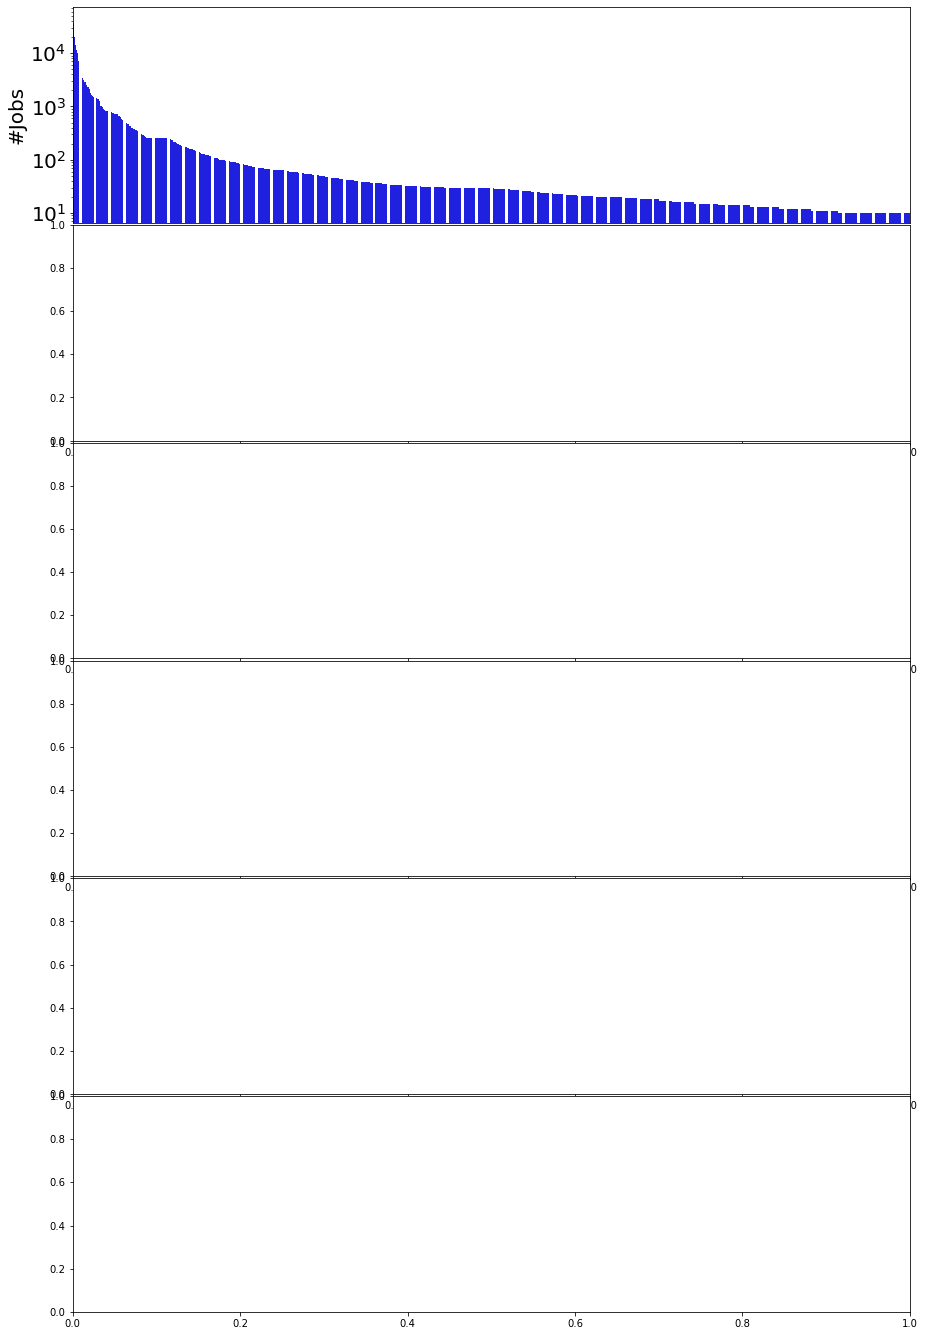

In [653]:
plot_input_stats(inp_stats, FIELDS5, "./InputStats-Columns.pdf")

3291
857361


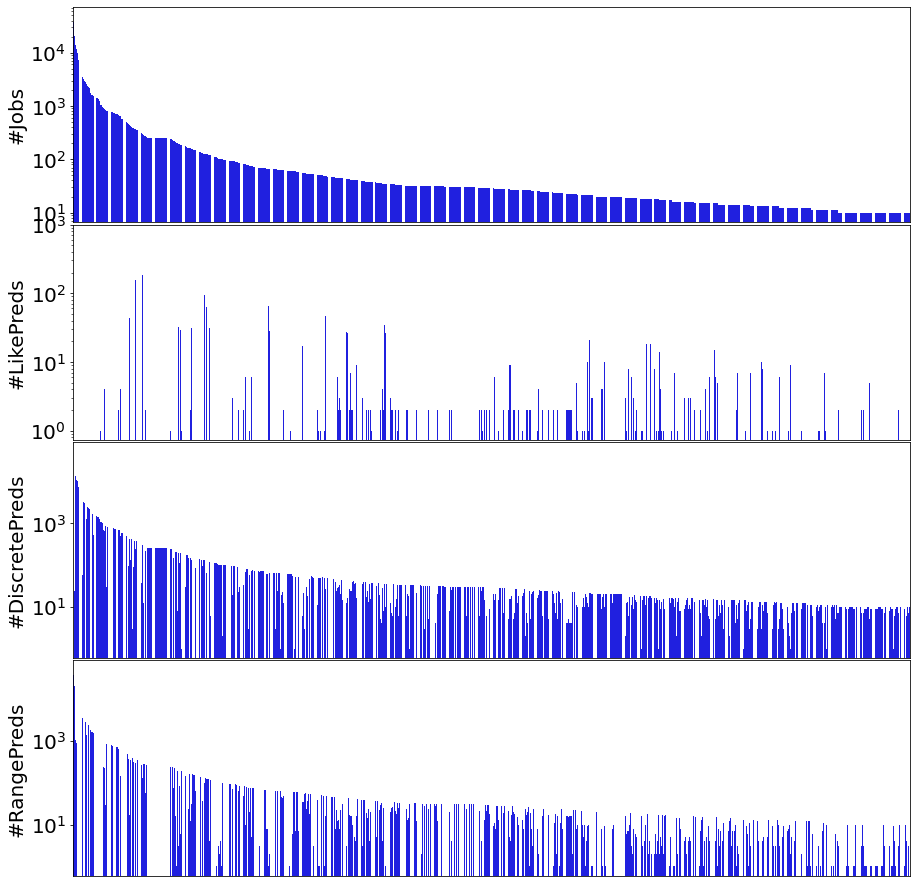

In [656]:
plot_input_stats(inp_stats, FIELDS, "./InputStats-FilterKinds.pdf")

90
8108


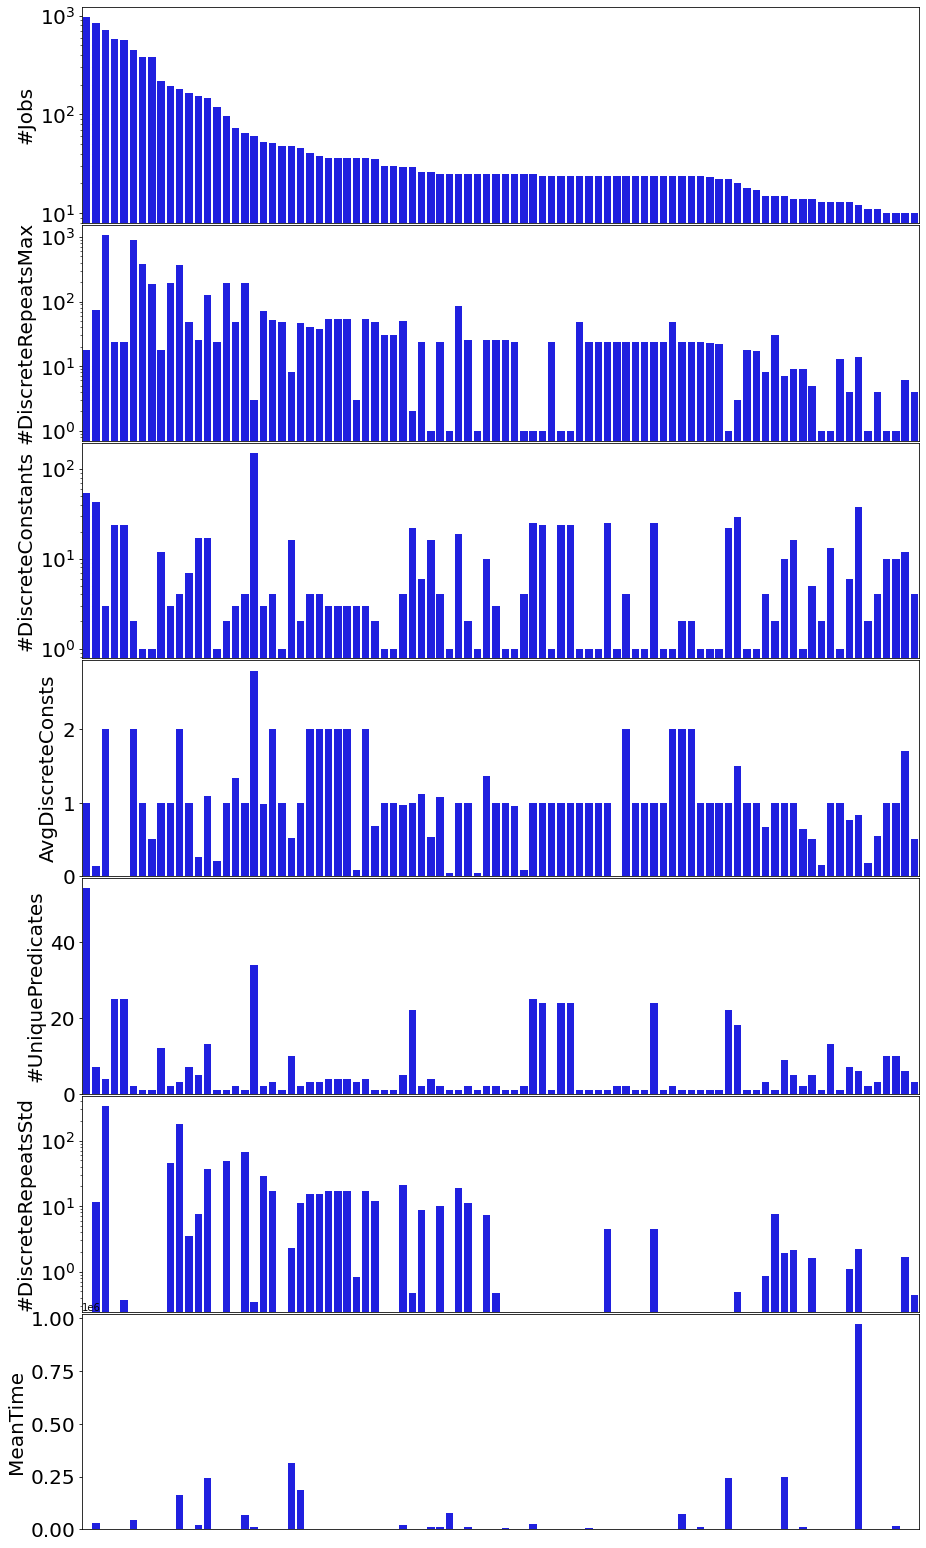

In [686]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
plot_input_stats(inp_stats2, FIELDS2, "/Users/pari/Desktop/InputStats-DiscreteConstants.pdf")

# Most of the repeated discrete values seem to be from shifting continuous values ---> sliding date windows

In [708]:
#inp_stats2.head(1)
for i in range(2):
    val = inp_stats2[INP_FIELD].values[i]
    #print(val)
    print(inp_to_discrete_consts[val])
    dfinp = df[df[INP_FIELD] == val]
    print(dfinp[FILTER_FIELD].values)

{'@"MSXLEADCOMPETITORS"': 18, '@"MSXLEAD"': 18, '@"MSXTERRITORY"': 18, '@"MSXCONSUMPTIONSERVICE"': 18, '@"MSXDYNAMICPROPERTY"': 18, '@"MSXPARTNERACCOUNT"': 18, '@"MSXBUSINESSUNIT"': 18, '@"MSXSALESORDER"': 18, '@"MSXPROCESSSTAGE"': 18, '@"MSXCONSENT"': 18, '@"MSXCAMPAIGN"': 18, '@"MSXLISTMEMBERBATCHES"': 18, '@"MSXLISTMEMBERS"': 18, '@"MSXPRODUCT"': 18, '@"MSXSELLERAPPCONSENT"': 18, '@"MSXTRANSACTIONCURRENCY"': 18, '@"MSXCOMPETITOR"': 18, '@"MSXEMAIL"': 18, '@"MSXSTRINGMAP"': 18, '@"MSXPRICELEVEL"': 18, '@"MSXLICENSINGPROGRAM"': 18, '@"MSXPRODUCTASSOCIATION"': 18, '@"MSXCAMPAIGNACTIVITY"': 18, '@"MSXAPP"': 18, '@"MSXSALESORDERDETAIL"': 18, '@"MSXCONTACT"': 18, '@"MSXACTIVITYPARTY"': 18, '@"MSXFAX"': 18, '@"MSXPHONECALL"': 18, '@"MSXOPPORTUNITYPRODUCT"': 18, '@"MSXTAXONOMYTYPE"': 18, '@"MSXCAMPAIGNRESPONSE"': 18, '@"MSXORDERCLOSE"': 18, '@"MSXAPPOINTMENT"': 18, '@"MSXACCOUNTDEVICEPROFILE"': 18, '@"MSXTAXONOMYTYPEDEPTH"': 18, '@"MSXOPPORTUNITYTEAM"': 18, '@"MSXCONSUMPTIONESTIMATE"': 18, 

In [ ]:
#INPNAME = "adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss"


20
2159


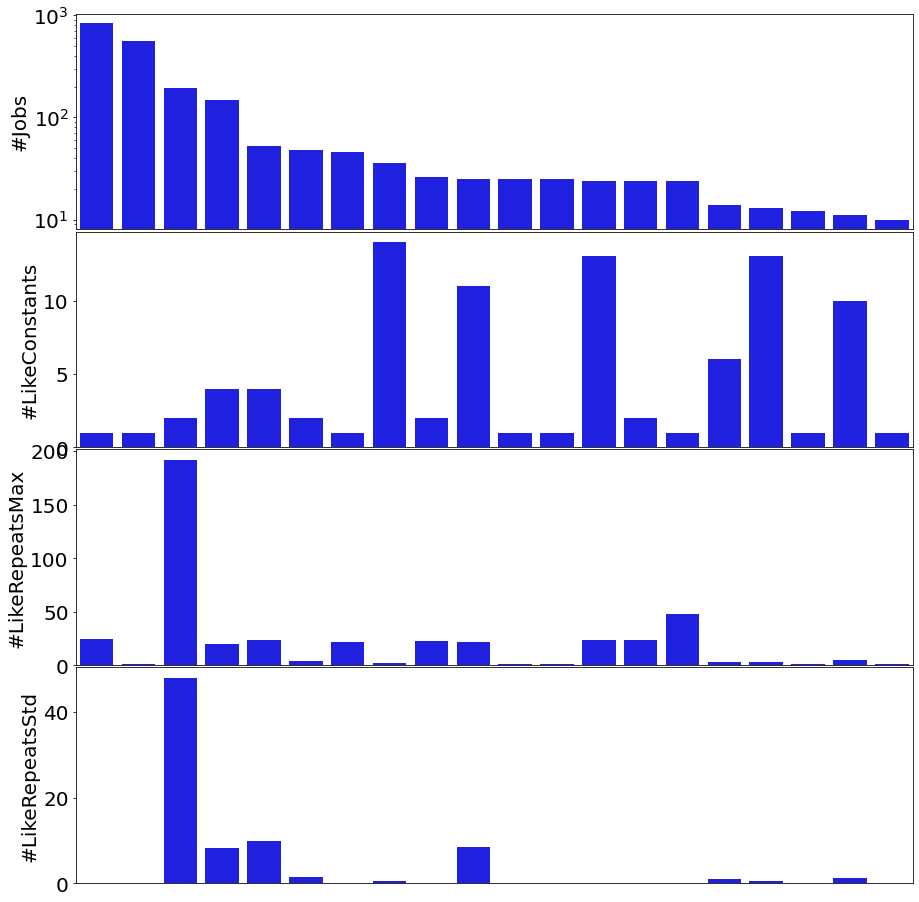

In [687]:
inp_stats3 = inp_stats[inp_stats["#LikeConstants"] != 0]
plot_input_stats(inp_stats3, FIELDS3, "/Users/pari/Desktop/InputStats-LikeConstants.pdf")

NameError: name 'inp_to_discdata' is not defined

226
16619


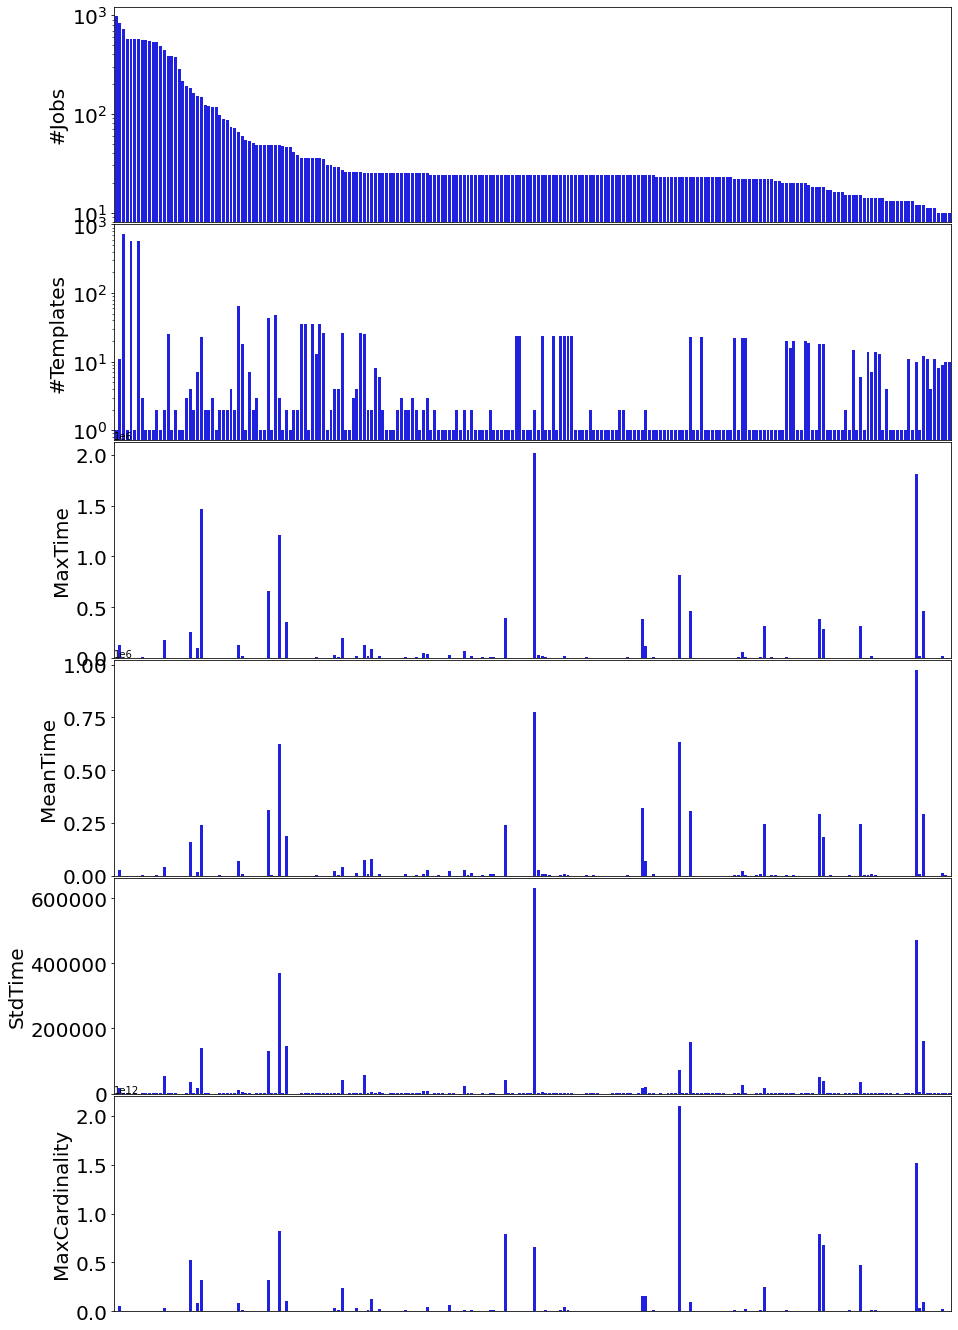

In [690]:
plot_input_stats(inp_stats, FIELDS4, "/Users/pari/Desktop/InputStats-Time.pdf")

# Exploring correlations

In [226]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AvgDiscreteConsts', 'MaxTime',
       'MeanTime', 'StdTime', 'MaxCardinality', '#LikePreds', '#RangePreds',
       '#DiscretePreds', '#UDFPreds', '#InPreds', '#EqualtoDate',
       'AllFilterColumns', 'FilterInPartition', '#DiscreteRepeatsMax',
       '#DiscreteConstants', '#DiscreteRepeatsStd', '#UniquePredicates',
       '#LikeConstants', '#LikeRepeatsMax', '#LikeRepeatsStd'],
      dtype='object')

In [227]:
corr_matrix = inp_stats.corr().abs()
corr_matrix["MaxTime"].reset_index().sort_values(by="MaxTime", ascending=False)

,index,MaxTime
9,MaxTime,1.000000
11,StdTime,0.990607
10,MeanTime,0.946467
1,Selectivity (std),0.462000
12,MaxCardinality,0.263619
2,Cardinality (std),0.240504
6,#Templates,0.208141
19,AllFilterColumns,0.090456
17,#InPreds,0.051782
4,#SelColumns (std),0.050232


# Exploring discrete constants

In [561]:
inp2 = inp_stats.sort_values("#DiscreteConstants", ascending=False)
print(inp2["NormInput"].head(10).values)
inp2.head(100)

<StringArray>
[                                                    'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss',
                          'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss',
                                                      'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Common/Dimensions/DimApp/VX/DimApp.ss',
 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
            'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
                                                                   'adl://iebks-proddata-cX.azuredatalakestore.net/local/xblpet/cooked/data/vulcandb/db

,NormInput,#Jobs,Selectivity (std),Cardinality (std),#InpColumns (std),#SelColumns (std),#FilterColumns,#Templates,#PartitionColumns,AvgDiscreteConsts,...,#EqualtoDate,AllFilterColumns,FilterInPartition,#DiscreteRepeatsMax,#DiscreteConstants,#DiscreteRepeatsStd,#UniquePredicates,#LikeConstants,#LikeRepeatsMax,#LikeRepeatsStd
206,adl://supportanalytics-cX.azuredatalakestore.n...,71,0.001113,16697762.262756,2.576789,0.0,1,18,0.0,2.521127,...,0,4,0,5,152,0.574708,34,0,0,0.0
24,adl://jarvis-prod-cX.azuredatalakestore.net/lo...,972,0.011565,295.506982,0.0,0.0,1,1,2.0,1.0,...,0,1,2,18,54,0.000000,54,0,0,0.0
791,adl://asimov-prod-data-cX.azuredatalakestore.n...,10,0.002359,176155032.70555,0.0,2.898275,2,7,1.0,6.0,...,0,3,0,3,47,0.492589,9,0,0,0.0
144,adl://asimov-prod-data-cX.azuredatalakestore.n...,120,0.000268,72927.008781,0.0,11.544288,1,3,3.0,46.0,...,0,1,2,120,46,0.000000,1,0,0,0.0
28,adl://asimov-prod-data-cX.azuredatalakestore.n...,882,0.004416,181374747.589422,15.775453,3.027561,2,19,2.938776,0.401361,...,0,6,1,84,43,13.273183,7,1,36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,adl://protection-adhoc-cX.azuredatalakestore.n...,19,0.083748,34218.187507,12.296531,4.287886,6,18,2.0,0.842105,...,0,10,0,12,4,0.000000,3,0,0,0.0
695,adl://protection-adhoc-cX.azuredatalakestore.n...,20,0.081991,34950.804865,13.164546,4.536402,6,20,2.0,0.7,...,0,8,0,12,4,1.732051,3,0,0,0.0
317,adl://asimov-prod-data-cX.azuredatalakestore.n...,48,0.028858,6962020.947762,0.0,1.010582,3,2,1.0,1.5,...,0,3,0,48,4,10.392305,3,0,0,0.0
555,adl://asimov-prod-data-cX.azuredatalakestore.n...,24,0.0,682.532879,0.0,0.0,4,1,1.0,2.0,...,0,4,0,24,4,0.000000,2,0,0,0.0


In [566]:
inptmp = inp_stats[inp_stats["#Jobs"] == 4564]
#inptmp = inp_stats[inp_stats["#Jobs"] == 71]
#inptmp = inp_stats[inp_stats["Selectivity (std)"] == 0.001113]

#INPNAME = 'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss'
#INPNAME = 'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss'
#INPNAME = 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss'
#inptmp = inp_stats[inp_stats["NormInput"] == INPNAME]

inpid = inptmp["NormInput"].values[0]
print(inpid)
df2 = df[df["NormInput"] == inpid]
print("Num unique jobs: ", len(set(df2["jobid"])))
print("Cols used: ", len(set(df2["unique_filter_cols"])))
print("Cont Ops used: ", set(df2["cont_ops"]))
print("Discrete ops used: ", set(df2["discrete_ops"]))
print("Like ops used: ", set(df2["like_ops"]))
print(df2.keys())
#df2
discdata = inp_to_discrete_consts[inpid]
print(discdata)
print(len(set(df2[FILTER_FIELD])))
print(df2[FILTER_FIELD].values[30])
print(len(set(df2["HashTagNonStrict"])))

adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Incident/Incident.Unified/Incident.Unified.ss
Num unique jobs:  621
Cols used:  4
Cont Ops used:  {0, 1}
Discrete ops used:  {0, 1}
Like ops used:  {0, 1}
Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       'num_cols_all', 'num_cols_sel', 'num_pcols', 'like_ops', 'discrete_ops',
       'cont_ops', 'udf_ops', 'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')
{'"MSSolveODS"': 4530, 'null': 3, '"Closed"': 1}
36
{"isComparison":true,"expOperator":"!=","attribute":{"name":"DataSource:26","dataType":"String

# Exploring Like filters

In [ ]:
# for k,v in inp_to_discrete_consts.items():
#     print(k,v)
#     print("**********")

In [ ]:
#plot_input_stats(inp_stats, FIELDS3, "/Users/pari/Desktop/InputStats3-DiffTemplates.pdf")

# Most filters of the kind

In [ ]:
tmp_df = df[df.HashTagInput == 11700902958082612250]
print(tmp_df[FILTER_FIELD].values[0])

In [ ]:
tmp_df = df[df.HashTagInput == 3929217785330710594]
print(tmp_df[FILTER_FIELD].values[1])

In [ ]:
test_attr = tmp_df[FILTER_FIELD].values[1]
d = json.loads(test_attr)
col_names = extract_values(d, "name")
col_names

In [ ]:
test_attr

In [ ]:
len(inp_to_cols[3929217785330710594])

In [ ]:
test = inp_stats[inp_stats["HashTagInput"] == 3929217785330710594]
test

In [ ]:
inp_to_cols[test["HashTagInput"].values[0]]

In [ ]:
type(test["HashTagInput"].values[0])
#test = test.convert_dtypes()

In [ ]:
for idx,row in test.iterrows():
    print(type(row["HashTagInput"]))
    print(int(row["HashTagInput"]))
    print(row["HashTagInput"])

# Exploring columns per input

In [ ]:
df.groupby(["HashTagInput", "inputColumns"]).describe()

# How many sorted columns vs unsorted